In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
import random
from models_adni import ModelA, ModelB
from hyperparameter_options import params_baseline as hyperparams

In [7]:
gpu = 2
multi_gpus = [2, 3]
zero_one_normalize = False

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
# path to be used for all data sets
train_data_path = "/ritter/share/data/ADNI_HDF5/Splits_Eitel/10xrandom_splits/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_random_state"

In [10]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        #self.X = X
        #self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [11]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [12]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [13]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load data sets
        train_h5 = h5py.File(train_data_path + str(r) + ".h5", 'r')
        val_h5 = h5py.File(train_data_path.replace("train", "val") + str(r) + ".h5", 'r')
        
        X_train, y_train = np.array(train_h5['X']), np.array(train_h5['y'])
        X_val, y_val = val_h5['X'], val_h5['y']

        # dataset overview
        y = np.concatenate([np.array(y_train), np.array(y_val)])
        print("# of patients {}, # of healthy controls {}".format(np.sum(y), len(y)-np.sum(y)))

        print(len(y_train))
        print(len(y_val))
        
        if zero_one_normalize:
            intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_h5.close()
        val_h5.close()
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelA"
            elif inner_fold < 4:
                model_name = "ModelB"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1
            
            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
            
            train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
            )
            val_loader = DataLoader(
                adni_data_val, batch_size=1, num_workers=1, shuffle=True
            )
        
            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=50,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models


In [14]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [15]:
r = 0

In [16]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/10xrandom_splits/baseline/"
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

###### Starting outer fold 0
# of patients 410, # of healthy controls 396
699
107
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69528
Time elapsed: 0h:0m:10s
train accuracy_score: 49.50 %
train balanced_accuracy: 49.33 %
val accuracy_score: 53.27 %
val balanced_accuracy: 49.45 %
Val loss: 0.691228
[1,    50] loss: 0.69498
Time elapsed: 0h:0m:18s
train accuracy_score: 53.08 %
train balanced_accuracy: 52.34 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.687092
[2,    50] loss: 0.68783
Time elapsed: 0h:0m:27s
train accuracy_score: 52.36 %
train balanced_accuracy: 53.15 %
val accuracy_score: 57.01 %
val balanced_accuracy: 59.87 %
Val loss: 0.687750
[3,    50] loss: 0.68940
Time elapsed: 0h:0m:36s
train accuracy_score: 56.65 %
train balanced_accuracy: 56.26 %
val accuracy_score: 61.68 %
val balanced_accuracy: 60.06 %
Val loss: 0.675674
[4,    50] loss: 0.68367
T

[42,    50] loss: 0.28908
Time elapsed: 0h:6m:23s
train accuracy_score: 86.98 %
train balanced_accuracy: 87.03 %
val accuracy_score: 85.05 %
val balanced_accuracy: 85.89 %
Val loss: 0.522954
[43,    50] loss: 0.32243
Time elapsed: 0h:6m:32s
train accuracy_score: 85.69 %
train balanced_accuracy: 85.69 %
val accuracy_score: 85.05 %
val balanced_accuracy: 84.94 %
Val loss: 0.430986
[44,    50] loss: 0.28885
Time elapsed: 0h:6m:40s
train accuracy_score: 87.84 %
train balanced_accuracy: 87.85 %
val accuracy_score: 87.85 %
val balanced_accuracy: 88.16 %
Val loss: 0.452579
[45,    50] loss: 0.29136
Time elapsed: 0h:6m:49s
train accuracy_score: 87.27 %
train balanced_accuracy: 87.28 %
val accuracy_score: 80.37 %
val balanced_accuracy: 79.84 %
Val loss: 0.444708
[46,    50] loss: 0.27554
Time elapsed: 0h:6m:58s
train accuracy_score: 89.27 %
train balanced_accuracy: 89.35 %
val accuracy_score: 85.05 %
val balanced_accuracy: 84.94 %
Val loss: 0.450403
[47,    50] loss: 0.24041
Time elapsed: 0h:7m

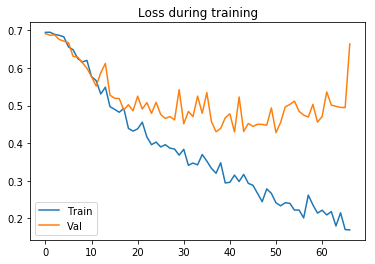

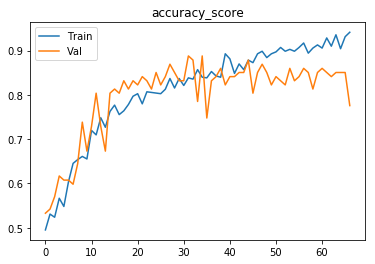

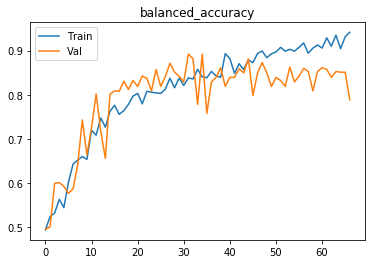

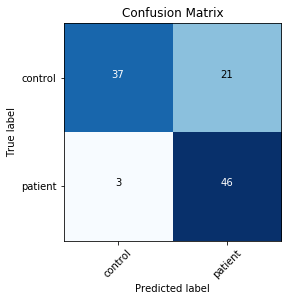

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69581
Time elapsed: 0h:0m:7s
train accuracy_score: 49.21 %
train balanced_accuracy: 49.28 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.688862
[1,    50] loss: 0.69603
Time elapsed: 0h:0m:16s
train accuracy_score: 46.21 %
train balanced_accuracy: 46.73 %
val accuracy_score: 58.88 %
val balanced_accuracy: 55.58 %
Val loss: 0.690412
[2,    50] loss: 0.69514
Time elapsed: 0h:0m:24s
train accuracy_score: 52.36 %
train balanced_accuracy: 51.61 %
val accuracy_score: 54.21 %
val balanced_accuracy: 50.00 %
Val loss: 0.685609
[3,    50] loss: 0.68618
Time elapsed: 0h:0m:33s
train accuracy_score: 57.80 %
train balanced_accuracy: 57.85 %
val accuracy_score: 53.27 %
val balanced_accuracy: 49.30 %
Val loss: 0.680941
[4,    50] loss: 0.68929
Time elapsed: 0h:0m:42s
train accuracy_score: 52.22 %
train balanced_accuracy: 52.39

val accuracy_score: 85.05 %
val balanced_accuracy: 84.94 %
Val loss: 0.417549
[43,    50] loss: 0.23985
Time elapsed: 0h:6m:26s
train accuracy_score: 89.27 %
train balanced_accuracy: 89.27 %
val accuracy_score: 85.05 %
val balanced_accuracy: 84.94 %
Val loss: 0.428763
[44,    50] loss: 0.24876
Time elapsed: 0h:6m:35s
train accuracy_score: 88.41 %
train balanced_accuracy: 88.36 %
val accuracy_score: 84.11 %
val balanced_accuracy: 84.24 %
Val loss: 0.457851
[45,    50] loss: 0.24717
Time elapsed: 0h:6m:44s
train accuracy_score: 89.27 %
train balanced_accuracy: 89.28 %
val accuracy_score: 86.92 %
val balanced_accuracy: 86.66 %
Val loss: 0.431693
[46,    50] loss: 0.21852
Time elapsed: 0h:6m:52s
train accuracy_score: 90.27 %
train balanced_accuracy: 90.29 %
val accuracy_score: 85.05 %
val balanced_accuracy: 85.57 %
Val loss: 0.492538
[47,    50] loss: 0.20682
Time elapsed: 0h:7m:1s
train accuracy_score: 90.84 %
train balanced_accuracy: 90.82 %
val accuracy_score: 85.98 %
val balanced_accur

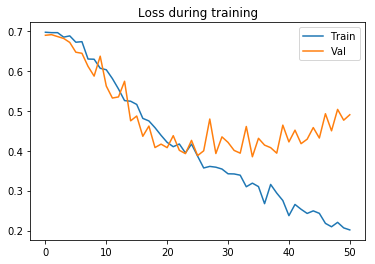

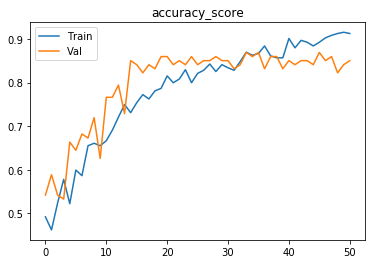

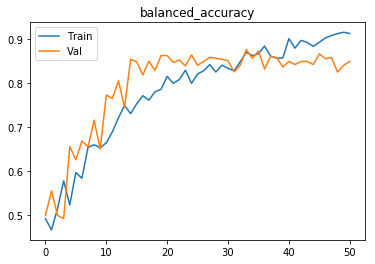

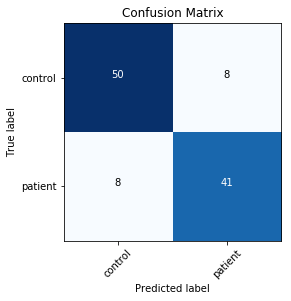

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69452
Time elapsed: 0h:0m:12s
train accuracy_score: 49.79 %
train balanced_accuracy: 50.16 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.695718
[1,    50] loss: 0.69501
Time elapsed: 0h:0m:26s
train accuracy_score: 48.35 %
train balanced_accuracy: 47.89 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.694055
[2,    50] loss: 0.69628
Time elapsed: 0h:0m:41s
train accuracy_score: 49.93 %
train balanced_accuracy: 49.94 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.694945
[3,    50] loss: 0.69438
Time elapsed: 0h:0m:55s
train accuracy_score: 47.93 %
train balanced_accuracy: 47.28 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.699175
[4,    50] loss: 0.69663
Time elapsed: 0h:1m:10s
train accuracy_score: 50.79 %
train balanced_accuracy: 49.77

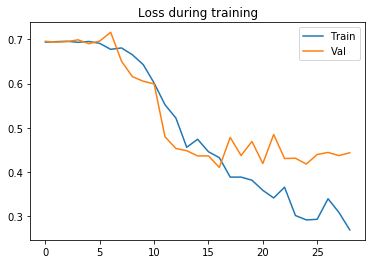

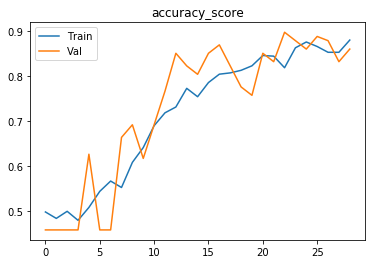

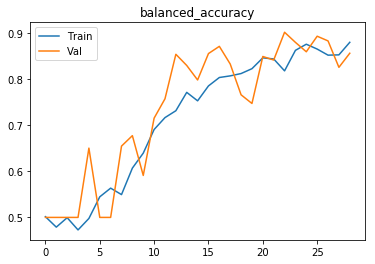

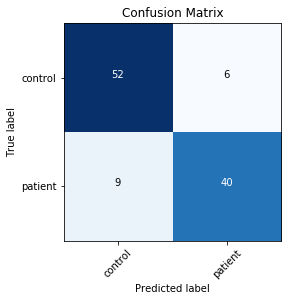

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69984
[0,   100] loss: 0.70165
Time elapsed: 0h:0m:15s
train accuracy_score: 46.21 %
train balanced_accuracy: 45.90 %
val accuracy_score: 53.27 %
val balanced_accuracy: 49.45 %
Val loss: 0.691864
[1,    50] loss: 0.69577
[1,   100] loss: 0.69737
Time elapsed: 0h:0m:32s
train accuracy_score: 50.93 %
train balanced_accuracy: 50.73 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.699444
[2,    50] loss: 0.70190
[2,   100] loss: 0.69664
Time elapsed: 0h:0m:50s
train accuracy_score: 51.79 %
train balanced_accuracy: 51.18 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.711703
[3,    50] loss: 0.70183
[3,   100] loss: 0.69673
Time elapsed: 0h:1m:7s
train accuracy_score: 50.50 %
train balanced_accuracy: 50.07 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.692901
[4,    50]

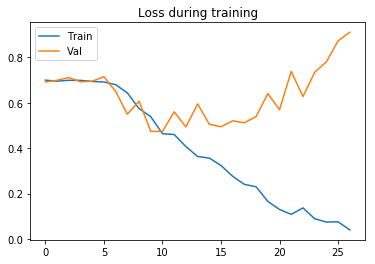

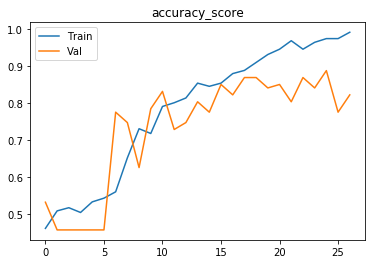

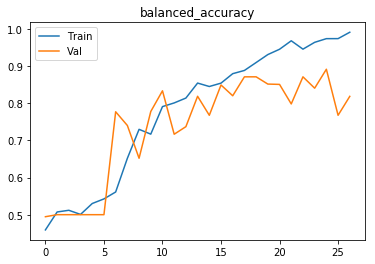

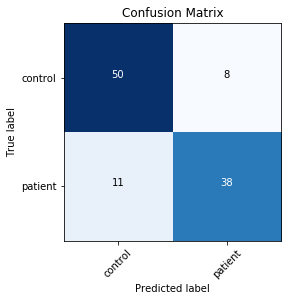

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69591
[0,   100] loss: 0.69910
Time elapsed: 0h:0m:9s
train accuracy_score: 48.35 %
train balanced_accuracy: 48.41 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
Val loss: 0.695975
[1,    50] loss: 0.69341
[1,   100] loss: 0.69871
Time elapsed: 0h:0m:20s
train accuracy_score: 50.21 %
train balanced_accuracy: 49.84 %
val accuracy_score: 61.68 %
val balanced_accuracy: 58.48 %
Val loss: 0.691762
[2,    50] loss: 0.69941
[2,   100] loss: 0.69547
Time elapsed: 0h:0m:31s
train accuracy_score: 49.07 %
train balanced_accuracy: 49.30 %
val accuracy_score: 53.27 %
val balanced_accuracy: 49.45 %
Val loss: 0.690774
[3,    50] loss: 0.69672
[3,   100] loss: 0.69296
Time elapsed: 0h:0m:43s
train accuracy_score: 50.79 %
train balanced_accuracy: 50.14 %
val accuracy_score: 67.29 %
val balanced_accuracy: 65.87 %
Val loss: 0.691132
[4,    50]

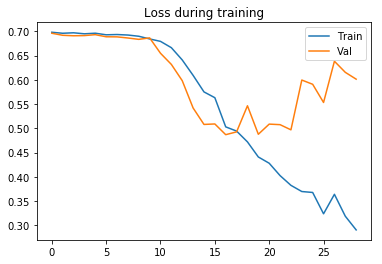

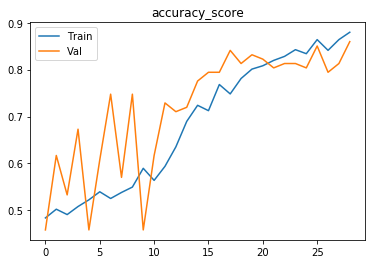

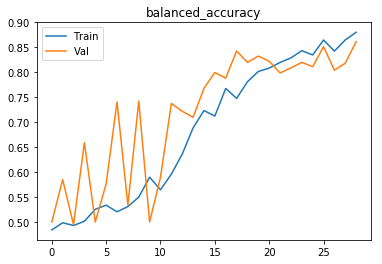

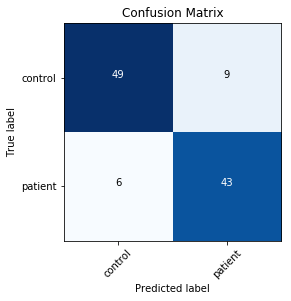

Finished outer fold.
{'final_acc': 0.8564391273750879, 'best_acc': 0.9020056298381421, 'final_iter': 29, 'best_iter': 23, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 1
# of patients 398, # of healthy controls 395
698
95
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69698
[0,   100] loss: 0.69937
[0,   150] loss: 0.69687
Time elapsed: 0h:0m:11s
train accuracy_score: 46.42 %
train balanced_accuracy: 46.92 %
val accuracy_score: 46.32 %
val balanced_accuracy: 53.64 %
Val loss: 0.693571
[1,    50] loss: 0.69257
[1,   100] loss: 0.69254
[1,   150] loss: 0.69980
Time elapsed: 0h:0m:24s
train accuracy_score: 51.43 %
train balanced_accuracy: 51.12 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.697748
[2,    50] loss: 0.68952
[2,   100] loss: 0.69522
[2,   150] loss: 0.69916
Time elapsed:

[32,   100] loss: 0.48702
[32,   150] loss: 0.54562
Time elapsed: 0h:7m:7s
train accuracy_score: 73.93 %
train balanced_accuracy: 73.97 %
val accuracy_score: 72.63 %
val balanced_accuracy: 73.30 %
Val loss: 0.503082
[33,    50] loss: 0.52463
[33,   100] loss: 0.50138
[33,   150] loss: 0.56683
Time elapsed: 0h:7m:20s
train accuracy_score: 73.07 %
train balanced_accuracy: 73.05 %
val accuracy_score: 74.74 %
val balanced_accuracy: 74.43 %
Val loss: 0.486173
[34,    50] loss: 0.52921
[34,   100] loss: 0.51804
[34,   150] loss: 0.52409
Time elapsed: 0h:7m:34s
train accuracy_score: 73.78 %
train balanced_accuracy: 73.82 %
val accuracy_score: 73.68 %
val balanced_accuracy: 73.86 %
Val loss: 0.479219
[35,    50] loss: 0.51659
[35,   100] loss: 0.47117
[35,   150] loss: 0.55001
Time elapsed: 0h:7m:47s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.75 %
val accuracy_score: 74.74 %
val balanced_accuracy: 73.75 %
Val loss: 0.455942
[36,    50] loss: 0.50842
[36,   100] loss: 0.55281
[36

[66,    50] loss: 0.33169
[66,   100] loss: 0.29445
[66,   150] loss: 0.30122
Time elapsed: 0h:14m:31s
train accuracy_score: 87.68 %
train balanced_accuracy: 87.71 %
val accuracy_score: 88.42 %
val balanced_accuracy: 87.95 %
Val loss: 0.261718
[67,    50] loss: 0.34899
[67,   100] loss: 0.30469
[67,   150] loss: 0.28907
Time elapsed: 0h:14m:43s
train accuracy_score: 85.67 %
train balanced_accuracy: 85.69 %
val accuracy_score: 88.42 %
val balanced_accuracy: 88.30 %
Val loss: 0.269717
[68,    50] loss: 0.26765
[68,   100] loss: 0.32858
[68,   150] loss: 0.31159
Time elapsed: 0h:14m:56s
train accuracy_score: 88.68 %
train balanced_accuracy: 88.70 %
val accuracy_score: 87.37 %
val balanced_accuracy: 85.34 %
Val loss: 0.286766
[69,    50] loss: 0.32034
[69,   100] loss: 0.23023
[69,   150] loss: 0.24667
Time elapsed: 0h:15m:9s
train accuracy_score: 89.26 %
train balanced_accuracy: 89.26 %
val accuracy_score: 89.47 %
val balanced_accuracy: 89.20 %
Val loss: 0.253825
[70,    50] loss: 0.27289

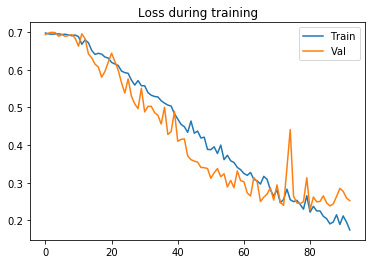

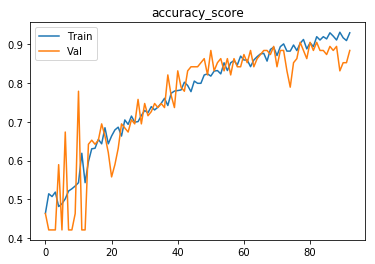

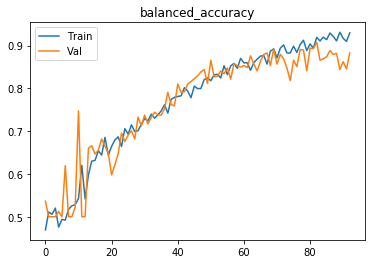

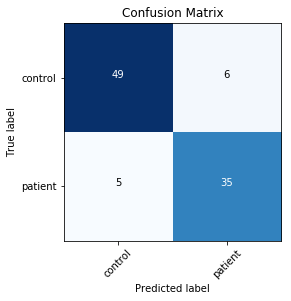

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69755
[0,   100] loss: 0.69852
Time elapsed: 0h:0m:9s
train accuracy_score: 48.14 %
train balanced_accuracy: 48.64 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.709859
[1,    50] loss: 0.69970
[1,   100] loss: 0.69635
Time elapsed: 0h:0m:20s
train accuracy_score: 47.99 %
train balanced_accuracy: 47.88 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.697591
[2,    50] loss: 0.69492
[2,   100] loss: 0.69669
Time elapsed: 0h:0m:30s
train accuracy_score: 49.71 %
train balanced_accuracy: 49.79 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690512
[3,    50] loss: 0.69343
[3,   100] loss: 0.69788
Time elapsed: 0h:0m:41s
train accuracy_score: 49.86 %
train balanced_accuracy: 49.86 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685295
[4,    50]

val accuracy_score: 75.79 %
val balanced_accuracy: 77.73 %
Val loss: 0.457046
[38,    50] loss: 0.25179
[38,   100] loss: 0.24640
Time elapsed: 0h:7m:8s
train accuracy_score: 89.97 %
train balanced_accuracy: 89.99 %
val accuracy_score: 82.11 %
val balanced_accuracy: 80.11 %
Val loss: 0.404013
[39,    50] loss: 0.24336
[39,   100] loss: 0.35415
Time elapsed: 0h:7m:20s
train accuracy_score: 87.54 %
train balanced_accuracy: 87.52 %
val accuracy_score: 68.42 %
val balanced_accuracy: 71.70 %
Val loss: 0.597451
[40,    50] loss: 0.22936
[40,   100] loss: 0.25409
Time elapsed: 0h:7m:31s
train accuracy_score: 89.54 %
train balanced_accuracy: 89.55 %
val accuracy_score: 82.11 %
val balanced_accuracy: 82.16 %
Val loss: 0.360812
[41,    50] loss: 0.22579
[41,   100] loss: 0.25872
Time elapsed: 0h:7m:42s
train accuracy_score: 92.26 %
train balanced_accuracy: 92.27 %
val accuracy_score: 82.11 %
val balanced_accuracy: 82.50 %
Val loss: 0.373077
[42,    50] loss: 0.19434
[42,   100] loss: 0.18199
Tim

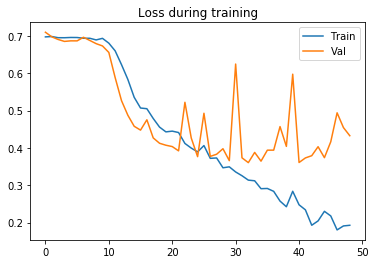

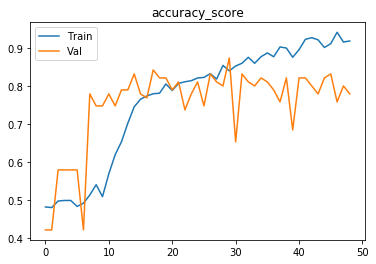

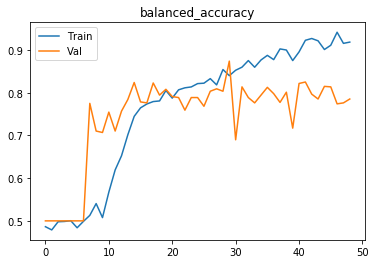

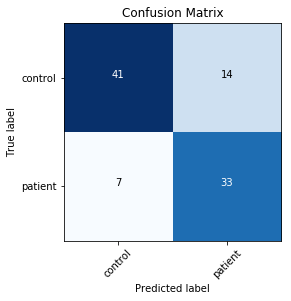

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69699
Time elapsed: 0h:0m:12s
train accuracy_score: 47.56 %
train balanced_accuracy: 47.88 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.690708
[1,    50] loss: 0.69636
Time elapsed: 0h:0m:26s
train accuracy_score: 47.13 %
train balanced_accuracy: 47.18 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685445
[2,    50] loss: 0.69657
Time elapsed: 0h:0m:40s
train accuracy_score: 47.13 %
train balanced_accuracy: 47.20 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.682894
[3,    50] loss: 0.69269
Time elapsed: 0h:0m:55s
train accuracy_score: 51.15 %
train balanced_accuracy: 51.29 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.712154
[4,    50] loss: 0.69521
Time elapsed: 0h:1m:9s
train accuracy_score: 51.86 %
train balanced_accuracy: 51.61

val accuracy_score: 87.37 %
val balanced_accuracy: 85.00 %
Val loss: 0.366988
[43,    50] loss: 0.01966
Time elapsed: 0h:10m:22s
train accuracy_score: 99.43 %
train balanced_accuracy: 99.42 %
val accuracy_score: 86.32 %
val balanced_accuracy: 83.75 %
Val loss: 0.460019
[44,    50] loss: 0.04797
Time elapsed: 0h:10m:36s
train accuracy_score: 98.85 %
train balanced_accuracy: 98.85 %
val accuracy_score: 86.32 %
val balanced_accuracy: 83.75 %
Val loss: 0.480219
[45,    50] loss: 0.02417
Time elapsed: 0h:10m:50s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.28 %
val accuracy_score: 86.32 %
val balanced_accuracy: 83.75 %
Val loss: 0.571572
[46,    50] loss: 0.01027
Time elapsed: 0h:11m:4s
train accuracy_score: 99.57 %
train balanced_accuracy: 99.57 %
val accuracy_score: 77.89 %
val balanced_accuracy: 79.89 %
Val loss: 0.660815
[47,    50] loss: 0.02346
Time elapsed: 0h:11m:19s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.27 %
val accuracy_score: 84.21 %
val balanced_

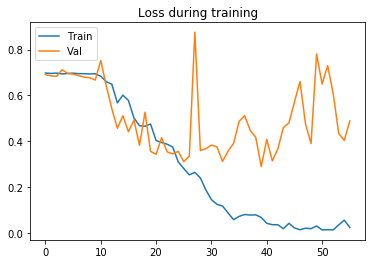

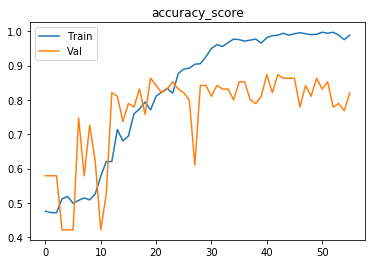

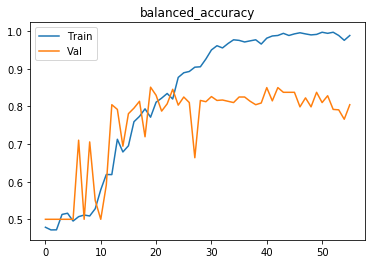

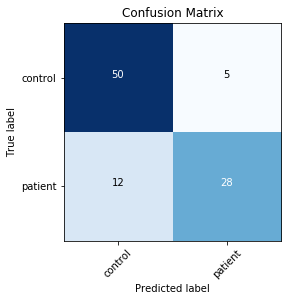

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69371
[0,   100] loss: 0.70077
[0,   150] loss: 0.69019
Time elapsed: 0h:0m:18s
train accuracy_score: 49.43 %
train balanced_accuracy: 48.67 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684858
[1,    50] loss: 0.69289
[1,   100] loss: 0.69658
[1,   150] loss: 0.69540
Time elapsed: 0h:0m:37s
train accuracy_score: 49.43 %
train balanced_accuracy: 49.23 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.695959
[2,    50] loss: 0.69493
[2,   100] loss: 0.69468
[2,   150] loss: 0.69338
Time elapsed: 0h:0m:58s
train accuracy_score: 49.86 %
train balanced_accuracy: 49.13 %
val accuracy_score: 62.11 %
val balanced_accuracy: 64.89 %
Val loss: 0.691355
[3,    50] loss: 0.69250
[3,   100] loss: 0.69613
[3,   150] loss: 0.69319
Time elapsed: 0h:1m:18s
train accuracy_score: 47.85 %
train balanced_accura

Time elapsed: 0h:11m:24s
train accuracy_score: 96.56 %
train balanced_accuracy: 96.56 %
val accuracy_score: 94.74 %
val balanced_accuracy: 94.09 %
Val loss: 0.138288
[34,    50] loss: 0.04142
[34,   100] loss: 0.04660
[34,   150] loss: 0.05411
Time elapsed: 0h:11m:45s
train accuracy_score: 97.85 %
train balanced_accuracy: 97.85 %
val accuracy_score: 88.42 %
val balanced_accuracy: 90.00 %
Val loss: 0.299606
[35,    50] loss: 0.06612
[35,   100] loss: 0.03685
[35,   150] loss: 0.05230
Time elapsed: 0h:12m:5s
train accuracy_score: 98.71 %
train balanced_accuracy: 98.71 %
val accuracy_score: 93.68 %
val balanced_accuracy: 92.50 %
Val loss: 0.178152
[36,    50] loss: 0.05576
[36,   100] loss: 0.03435
[36,   150] loss: 0.04400
Time elapsed: 0h:12m:25s
train accuracy_score: 98.42 %
train balanced_accuracy: 98.43 %
val accuracy_score: 91.58 %
val balanced_accuracy: 92.05 %
Val loss: 0.170721
[37,    50] loss: 0.04690
[37,   100] loss: 0.04251
[37,   150] loss: 0.02494
Time elapsed: 0h:12m:45s


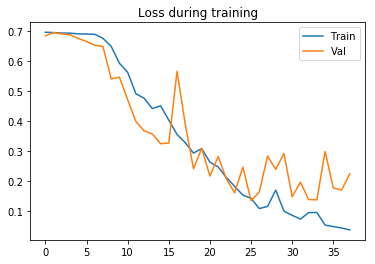

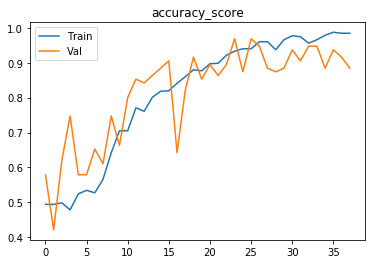

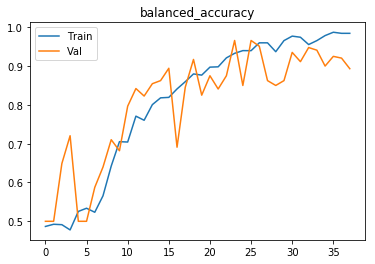

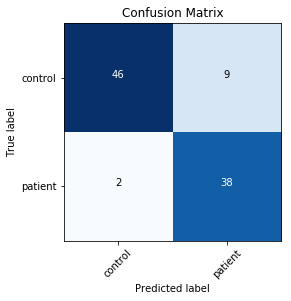

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69613
[0,   100] loss: 0.69743
[0,   150] loss: 0.69376
Time elapsed: 0h:0m:18s
train accuracy_score: 46.99 %
train balanced_accuracy: 47.34 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687561
[1,    50] loss: 0.69858
[1,   100] loss: 0.69320
[1,   150] loss: 0.69738
Time elapsed: 0h:0m:38s
train accuracy_score: 48.42 %
train balanced_accuracy: 48.52 %
val accuracy_score: 46.32 %
val balanced_accuracy: 53.64 %
Val loss: 0.693263
[2,    50] loss: 0.69644
[2,   100] loss: 0.69525
[2,   150] loss: 0.69668
Time elapsed: 0h:0m:58s
train accuracy_score: 50.86 %
train balanced_accuracy: 51.08 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.693899
[3,    50] loss: 0.69398
[3,   100] loss: 0.68068
[3,   150] loss: 0.69676
Time elapsed: 0h:1m:18s
train accuracy_score: 55.87 %
train balanced_accura

val accuracy_score: 86.32 %
val balanced_accuracy: 86.82 %
Val loss: 0.399370
[34,    50] loss: 0.05210
[34,   100] loss: 0.05082
[34,   150] loss: 0.05023
Time elapsed: 0h:11m:48s
train accuracy_score: 98.14 %
train balanced_accuracy: 98.13 %
val accuracy_score: 86.32 %
val balanced_accuracy: 86.14 %
Val loss: 0.339757
[35,    50] loss: 0.02565
[35,   100] loss: 0.11296
[35,   150] loss: 0.04483
Time elapsed: 0h:12m:8s
train accuracy_score: 97.99 %
train balanced_accuracy: 97.97 %
val accuracy_score: 86.32 %
val balanced_accuracy: 86.14 %
Val loss: 0.321579
[36,    50] loss: 0.02978
[36,   100] loss: 0.10325
[36,   150] loss: 0.04926
Time elapsed: 0h:12m:28s
train accuracy_score: 98.71 %
train balanced_accuracy: 98.71 %
val accuracy_score: 86.32 %
val balanced_accuracy: 86.14 %
Val loss: 0.335021
[37,    50] loss: 0.07900
[37,   100] loss: 0.04606
[37,   150] loss: 0.03923
Time elapsed: 0h:12m:48s
train accuracy_score: 97.85 %
train balanced_accuracy: 97.85 %
val accuracy_score: 84.21

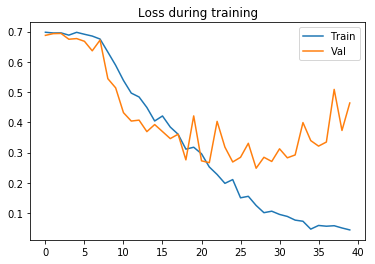

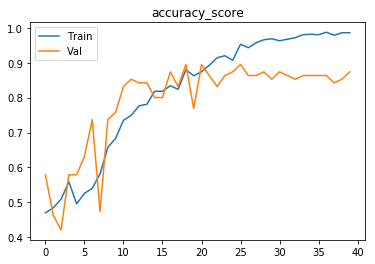

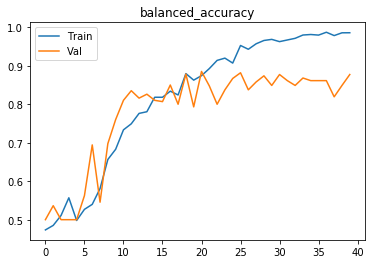

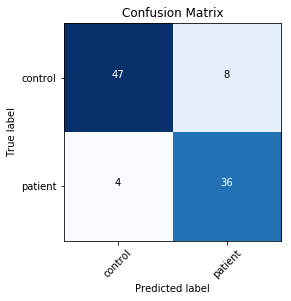

Finished outer fold.
{'final_acc': 0.8931818181818181, 'best_acc': 0.9659090909090908, 'final_iter': 38, 'best_iter': 26, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 2
# of patients 397, # of healthy controls 394
690
101
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69477
Time elapsed: 0h:0m:7s
train accuracy_score: 47.97 %
train balanced_accuracy: 48.46 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694014
[1,    50] loss: 0.69695
Time elapsed: 0h:0m:17s
train accuracy_score: 49.71 %
train balanced_accuracy: 49.60 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690915
[2,    50] loss: 0.69292
Time elapsed: 0h:0m:26s
train accuracy_score: 50.29 %
train balanced_accuracy: 50.33 %
val accuracy_score: 56.44 %
val balanced_accuracy: 54.31 %
Val loss: 0.6903

[41,    50] loss: 0.32993
Time elapsed: 0h:6m:31s
train accuracy_score: 85.51 %
train balanced_accuracy: 85.49 %
val accuracy_score: 74.26 %
val balanced_accuracy: 73.34 %
Val loss: 0.471878
[42,    50] loss: 0.27520
Time elapsed: 0h:6m:40s
train accuracy_score: 88.70 %
train balanced_accuracy: 88.73 %
val accuracy_score: 71.29 %
val balanced_accuracy: 72.21 %
Val loss: 0.506507
[43,    50] loss: 0.29860
Time elapsed: 0h:6m:49s
train accuracy_score: 86.09 %
train balanced_accuracy: 86.07 %
val accuracy_score: 77.23 %
val balanced_accuracy: 76.07 %
Val loss: 0.475893
[44,    50] loss: 0.31957
Time elapsed: 0h:6m:58s
train accuracy_score: 87.25 %
train balanced_accuracy: 87.27 %
val accuracy_score: 78.22 %
val balanced_accuracy: 77.87 %
Val loss: 0.483745
[45,    50] loss: 0.33361
Time elapsed: 0h:7m:8s
train accuracy_score: 84.20 %
train balanced_accuracy: 84.19 %
val accuracy_score: 76.24 %
val balanced_accuracy: 75.34 %
Val loss: 0.498176
[46,    50] loss: 0.29673
Time elapsed: 0h:7m:

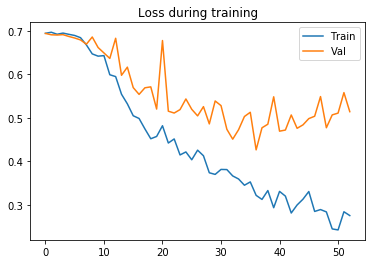

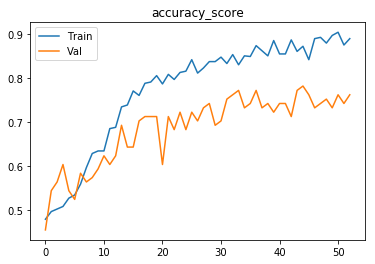

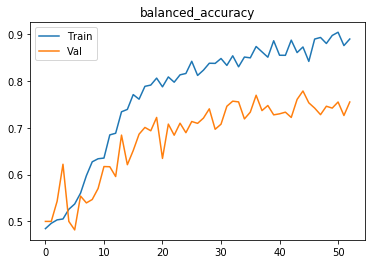

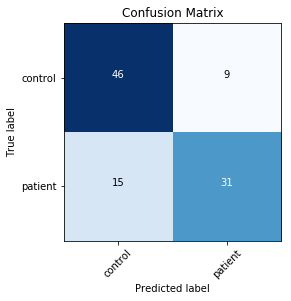

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69445
[0,   100] loss: 0.70586
[0,   150] loss: 0.69244
Time elapsed: 0h:0m:11s
train accuracy_score: 48.84 %
train balanced_accuracy: 49.21 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689734
[1,    50] loss: 0.69538
[1,   100] loss: 0.69263
[1,   150] loss: 0.69639
Time elapsed: 0h:0m:24s
train accuracy_score: 47.10 %
train balanced_accuracy: 47.51 %
val accuracy_score: 60.40 %
val balanced_accuracy: 63.28 %
Val loss: 0.692803
[2,    50] loss: 0.69380
[2,   100] loss: 0.69453
[2,   150] loss: 0.69159
Time elapsed: 0h:0m:38s
train accuracy_score: 50.58 %
train balanced_accuracy: 50.48 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692837
[3,    50] loss: 0.69572
[3,   100] loss: 0.69551
[3,   150] loss: 0.69207
Time elapsed: 0h:0m:52s
train accuracy_score: 48.55 %
train balanced_accura

val accuracy_score: 77.23 %
val balanced_accuracy: 76.07 %
Val loss: 0.466572
[34,    50] loss: 0.34588
[34,   100] loss: 0.31787
[34,   150] loss: 0.30937
Time elapsed: 0h:7m:48s
train accuracy_score: 88.26 %
train balanced_accuracy: 88.26 %
val accuracy_score: 78.22 %
val balanced_accuracy: 76.80 %
Val loss: 0.497911
[35,    50] loss: 0.33423
[35,   100] loss: 0.31387
[35,   150] loss: 0.30710
Time elapsed: 0h:8m:1s
train accuracy_score: 87.10 %
train balanced_accuracy: 87.10 %
val accuracy_score: 77.23 %
val balanced_accuracy: 77.49 %
Val loss: 0.455550
[36,    50] loss: 0.30744
[36,   100] loss: 0.31998
[36,   150] loss: 0.30049
Time elapsed: 0h:8m:15s
train accuracy_score: 87.10 %
train balanced_accuracy: 87.11 %
val accuracy_score: 76.24 %
val balanced_accuracy: 76.40 %
Val loss: 0.471419
[37,    50] loss: 0.32108
[37,   100] loss: 0.30420
[37,   150] loss: 0.29096
Time elapsed: 0h:8m:28s
train accuracy_score: 87.97 %
train balanced_accuracy: 87.99 %
val accuracy_score: 78.22 %
v

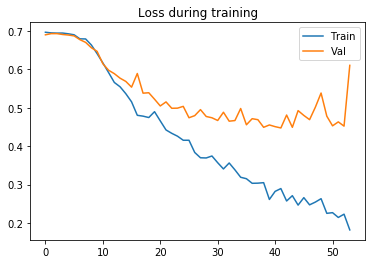

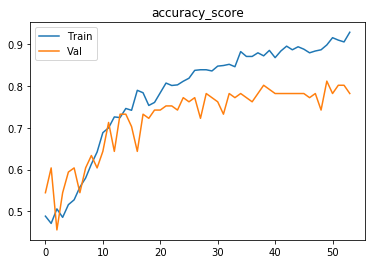

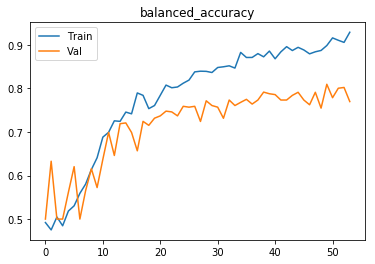

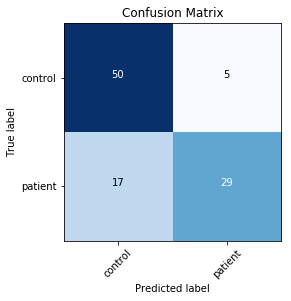

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69529
Time elapsed: 0h:0m:12s
train accuracy_score: 46.67 %
train balanced_accuracy: 46.72 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694932
[1,    50] loss: 0.69413
Time elapsed: 0h:0m:26s
train accuracy_score: 49.28 %
train balanced_accuracy: 49.01 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.696973
[2,    50] loss: 0.68801
Time elapsed: 0h:0m:41s
train accuracy_score: 56.52 %
train balanced_accuracy: 56.07 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.687597
[3,    50] loss: 0.69195
Time elapsed: 0h:0m:55s
train accuracy_score: 55.07 %
train balanced_accuracy: 54.96 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.684644
[4,    50] loss: 0.68616
Time elapsed: 0h:1m:10s
train accuracy_score: 55.65 %
train balanced_accuracy: 55.54

val accuracy_score: 76.24 %
val balanced_accuracy: 76.94 %
Val loss: 0.481452
[43,    50] loss: 0.10206
Time elapsed: 0h:10m:35s
train accuracy_score: 97.10 %
train balanced_accuracy: 97.10 %
val accuracy_score: 78.22 %
val balanced_accuracy: 78.04 %
Val loss: 0.476034
[44,    50] loss: 0.12031
Time elapsed: 0h:10m:49s
train accuracy_score: 95.65 %
train balanced_accuracy: 95.66 %
val accuracy_score: 76.24 %
val balanced_accuracy: 76.23 %
Val loss: 0.520809
[45,    50] loss: 0.11241
Time elapsed: 0h:11m:4s
train accuracy_score: 96.96 %
train balanced_accuracy: 96.96 %
val accuracy_score: 78.22 %
val balanced_accuracy: 78.58 %
Val loss: 0.482164
[46,    50] loss: 0.11321
Time elapsed: 0h:11m:18s
train accuracy_score: 96.09 %
train balanced_accuracy: 96.08 %
val accuracy_score: 78.22 %
val balanced_accuracy: 78.58 %
Val loss: 0.508614
[47,    50] loss: 0.07214
Time elapsed: 0h:11m:33s
train accuracy_score: 97.39 %
train balanced_accuracy: 97.41 %
val accuracy_score: 79.21 %
val balanced_

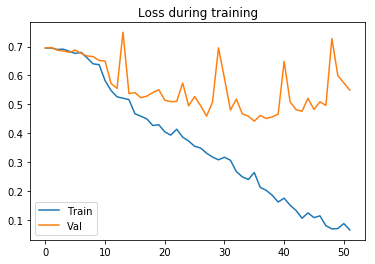

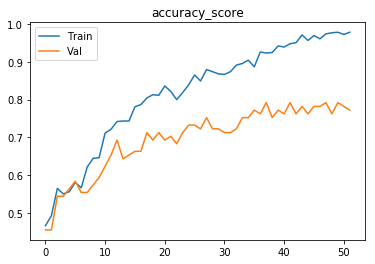

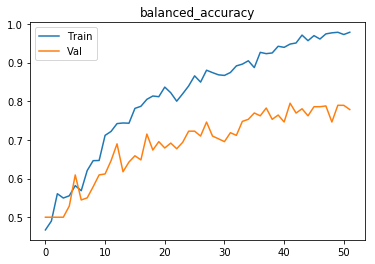

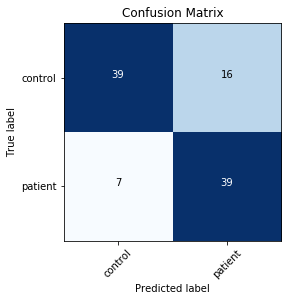

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69553
[0,   100] loss: 0.70297
Time elapsed: 0h:0m:14s
train accuracy_score: 49.28 %
train balanced_accuracy: 49.50 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691568
[1,    50] loss: 0.69683
[1,   100] loss: 0.69559
Time elapsed: 0h:0m:32s
train accuracy_score: 47.54 %
train balanced_accuracy: 47.83 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689231
[2,    50] loss: 0.69613
[2,   100] loss: 0.70059
Time elapsed: 0h:0m:49s
train accuracy_score: 48.41 %
train balanced_accuracy: 48.51 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688964
[3,    50] loss: 0.70072
[3,   100] loss: 0.69491
Time elapsed: 0h:1m:6s
train accuracy_score: 49.42 %
train balanced_accuracy: 49.63 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688829
[4,    50]

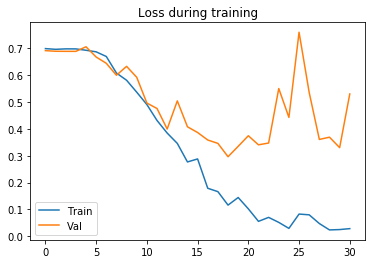

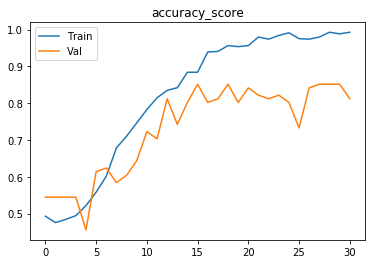

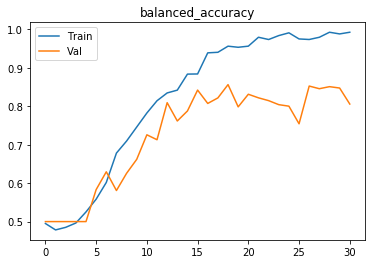

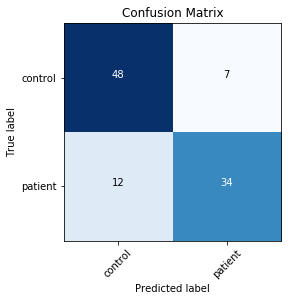

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69546
[0,   100] loss: 0.69244
[0,   150] loss: 0.69552
Time elapsed: 0h:0m:11s
train accuracy_score: 48.55 %
train balanced_accuracy: 49.36 %
val accuracy_score: 53.47 %
val balanced_accuracy: 57.09 %
Val loss: 0.693178
[1,    50] loss: 0.69636
[1,   100] loss: 0.69803
[1,   150] loss: 0.69189
Time elapsed: 0h:0m:24s
train accuracy_score: 47.68 %
train balanced_accuracy: 47.68 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688959
[2,    50] loss: 0.70018
[2,   100] loss: 0.69727
[2,   150] loss: 0.69387
Time elapsed: 0h:0m:38s
train accuracy_score: 47.39 %
train balanced_accuracy: 47.65 %
val accuracy_score: 52.48 %
val balanced_accuracy: 56.01 %
Val loss: 0.692842
[3,    50] loss: 0.69104
[3,   100] loss: 0.69871
[3,   150] loss: 0.69410
Time elapsed: 0h:0m:51s
train accuracy_score: 50.00 %
train balanced_accura

val accuracy_score: 74.26 %
val balanced_accuracy: 72.09 %
Val loss: 0.531318
[34,    50] loss: 0.36848
[34,   100] loss: 0.38228
[34,   150] loss: 0.41673
Time elapsed: 0h:7m:47s
train accuracy_score: 82.75 %
train balanced_accuracy: 82.81 %
val accuracy_score: 67.33 %
val balanced_accuracy: 68.04 %
Val loss: 0.519980
[35,    50] loss: 0.39015
[35,   100] loss: 0.41918
[35,   150] loss: 0.34739
Time elapsed: 0h:8m:0s
train accuracy_score: 83.62 %
train balanced_accuracy: 83.62 %
val accuracy_score: 72.28 %
val balanced_accuracy: 69.57 %
Val loss: 0.602719
[36,    50] loss: 0.43576
[36,   100] loss: 0.36319
[36,   150] loss: 0.32375
Time elapsed: 0h:8m:14s
train accuracy_score: 83.62 %
train balanced_accuracy: 83.67 %
val accuracy_score: 71.29 %
val balanced_accuracy: 71.15 %
Val loss: 0.515871
[37,    50] loss: 0.33458
[37,   100] loss: 0.34723
[37,   150] loss: 0.33619
Time elapsed: 0h:8m:27s
train accuracy_score: 85.07 %
train balanced_accuracy: 85.10 %
val accuracy_score: 72.28 %
v

val accuracy_score: 81.19 %
val balanced_accuracy: 80.95 %
Val loss: 0.400274
[68,    50] loss: 0.12976
[68,   100] loss: 0.22210
[68,   150] loss: 0.19401
Time elapsed: 0h:15m:24s
train accuracy_score: 92.46 %
train balanced_accuracy: 92.44 %
val accuracy_score: 81.19 %
val balanced_accuracy: 79.88 %
Val loss: 0.492875
[69,    50] loss: 0.20176
[69,   100] loss: 0.18203
[69,   150] loss: 0.18692
Time elapsed: 0h:15m:38s
train accuracy_score: 91.30 %
train balanced_accuracy: 91.33 %
val accuracy_score: 80.20 %
val balanced_accuracy: 80.04 %
Val loss: 0.414703
[70,    50] loss: 0.19957
[70,   100] loss: 0.16621
[70,   150] loss: 0.20299
Time elapsed: 0h:15m:52s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.74 %
val accuracy_score: 83.17 %
val balanced_accuracy: 81.52 %
Val loss: 0.555670
[71,    50] loss: 0.16702
[71,   100] loss: 0.19468
[71,   150] loss: 0.18019
Time elapsed: 0h:16m:5s
train accuracy_score: 91.74 %
train balanced_accuracy: 91.74 %
val accuracy_score: 84.16

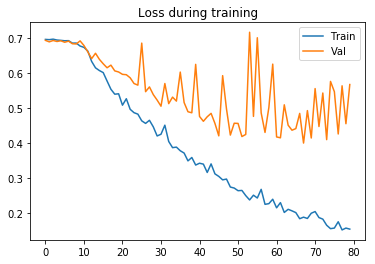

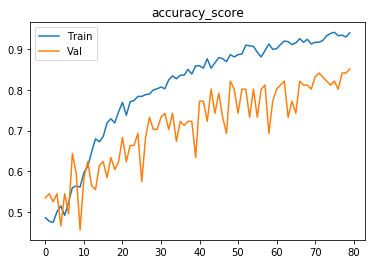

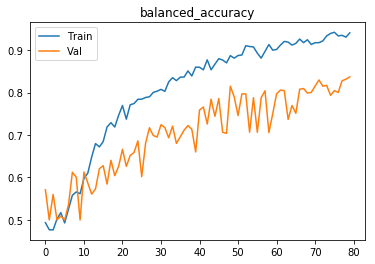

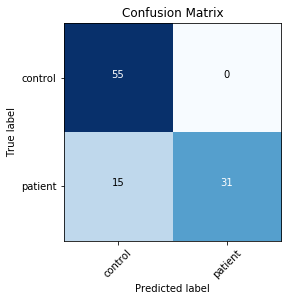

Finished outer fold.
{'final_acc': 0.8369565217391304, 'best_acc': 0.8369565217391304, 'final_iter': 80, 'best_iter': 80, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}
###### Starting outer fold 3
# of patients 405, # of healthy controls 401
708
98
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69328
Time elapsed: 0h:0m:7s
train accuracy_score: 51.41 %
train balanced_accuracy: 49.92 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.705293
[1,    50] loss: 0.69414
Time elapsed: 0h:0m:17s
train accuracy_score: 49.86 %
train balanced_accuracy: 48.71 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.698791
[2,    50] loss: 0.69317
Time elapsed: 0h:0m:26s
train accuracy_score: 52.12 %
train balanced_accuracy: 50.97 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.697373

[41,    50] loss: 0.41469
Time elapsed: 0h:6m:39s
train accuracy_score: 80.79 %
train balanced_accuracy: 80.86 %
val accuracy_score: 72.45 %
val balanced_accuracy: 75.09 %
Val loss: 0.490109
[42,    50] loss: 0.44996
Time elapsed: 0h:6m:49s
train accuracy_score: 80.65 %
train balanced_accuracy: 80.71 %
val accuracy_score: 76.53 %
val balanced_accuracy: 76.01 %
Val loss: 0.447565
[43,    50] loss: 0.42277
Time elapsed: 0h:6m:59s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.84 %
val accuracy_score: 74.49 %
val balanced_accuracy: 76.75 %
Val loss: 0.476416
[44,    50] loss: 0.42920
Time elapsed: 0h:7m:8s
train accuracy_score: 81.78 %
train balanced_accuracy: 81.87 %
val accuracy_score: 74.49 %
val balanced_accuracy: 76.75 %
Val loss: 0.493679
[45,    50] loss: 0.41479
Time elapsed: 0h:7m:18s
train accuracy_score: 81.92 %
train balanced_accuracy: 81.91 %
val accuracy_score: 71.43 %
val balanced_accuracy: 75.22 %
Val loss: 0.639847
[46,    50] loss: 0.42372
Time elapsed: 0h:7m:

[84,    50] loss: 0.31781
Time elapsed: 0h:13m:30s
train accuracy_score: 86.86 %
train balanced_accuracy: 86.92 %
val accuracy_score: 75.51 %
val balanced_accuracy: 78.07 %
Val loss: 0.497665
[85,    50] loss: 0.29054
Time elapsed: 0h:13m:40s
train accuracy_score: 87.57 %
train balanced_accuracy: 87.59 %
val accuracy_score: 72.45 %
val balanced_accuracy: 75.57 %
Val loss: 0.535157
[86,    50] loss: 0.30072
Time elapsed: 0h:13m:49s
train accuracy_score: 87.29 %
train balanced_accuracy: 87.31 %
val accuracy_score: 80.61 %
val balanced_accuracy: 81.75 %
Val loss: 0.398760
[87,    50] loss: 0.28040
Time elapsed: 0h:13m:59s
train accuracy_score: 89.12 %
train balanced_accuracy: 89.21 %
val accuracy_score: 80.61 %
val balanced_accuracy: 81.75 %
Val loss: 0.387292
[88,    50] loss: 0.28545
Time elapsed: 0h:14m:8s
train accuracy_score: 87.15 %
train balanced_accuracy: 87.12 %
val accuracy_score: 80.61 %
val balanced_accuracy: 82.24 %
Val loss: 0.421103
[89,    50] loss: 0.25398
Time elapsed: 0

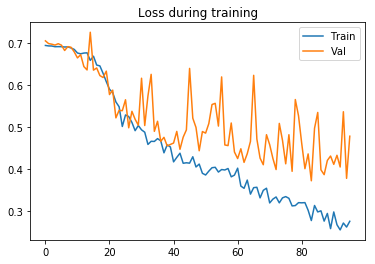

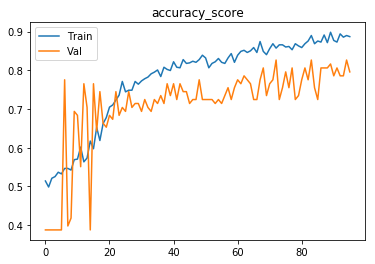

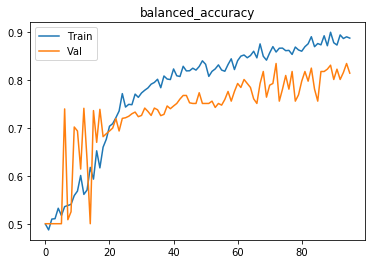

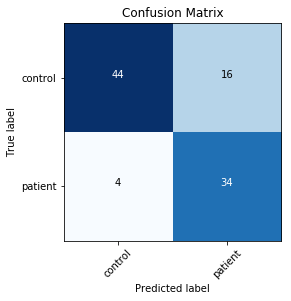

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69944
[0,   100] loss: 0.69437
Time elapsed: 0h:0m:9s
train accuracy_score: 47.18 %
train balanced_accuracy: 47.18 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.698545
[1,    50] loss: 0.69310
[1,   100] loss: 0.69548
Time elapsed: 0h:0m:20s
train accuracy_score: 50.71 %
train balanced_accuracy: 49.73 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
Val loss: 0.690521
[2,    50] loss: 0.69324
[2,   100] loss: 0.69517
Time elapsed: 0h:0m:31s
train accuracy_score: 46.33 %
train balanced_accuracy: 47.19 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.711204
[3,    50] loss: 0.69658
[3,   100] loss: 0.69683
Time elapsed: 0h:0m:43s
train accuracy_score: 49.29 %
train balanced_accuracy: 48.71 %
val accuracy_score: 55.10 %
val balanced_accuracy: 62.37 %
Val loss: 0.691935
[4,    50]

val accuracy_score: 81.63 %
val balanced_accuracy: 82.11 %
Val loss: 0.509334
[38,    50] loss: 0.22380
[38,   100] loss: 0.20279
Time elapsed: 0h:7m:19s
train accuracy_score: 90.54 %
train balanced_accuracy: 90.55 %
val accuracy_score: 78.57 %
val balanced_accuracy: 81.54 %
Val loss: 0.619208
[39,    50] loss: 0.20675
[39,   100] loss: 0.17607
Time elapsed: 0h:7m:30s
train accuracy_score: 92.80 %
train balanced_accuracy: 92.84 %
val accuracy_score: 80.61 %
val balanced_accuracy: 82.24 %
Val loss: 0.573113
[40,    50] loss: 0.18924
[40,   100] loss: 0.16645
Time elapsed: 0h:7m:42s
train accuracy_score: 94.07 %
train balanced_accuracy: 94.07 %
val accuracy_score: 80.61 %
val balanced_accuracy: 81.27 %
Val loss: 0.572475
[41,    50] loss: 0.25771
[41,   100] loss: 0.17515
Time elapsed: 0h:7m:53s
train accuracy_score: 90.96 %
train balanced_accuracy: 90.98 %
val accuracy_score: 79.59 %
val balanced_accuracy: 80.92 %
Val loss: 0.562216
[42,    50] loss: 0.15735
[42,   100] loss: 0.21539
Ti

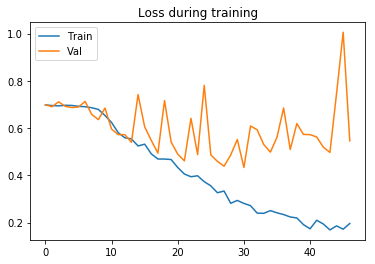

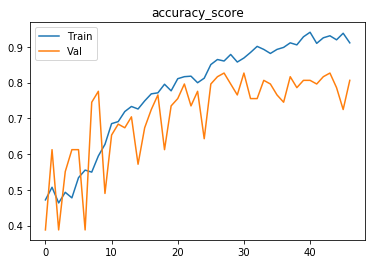

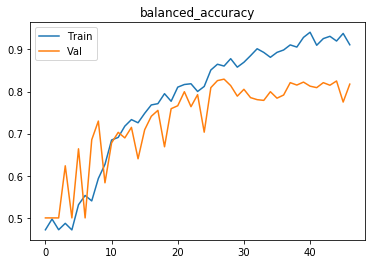

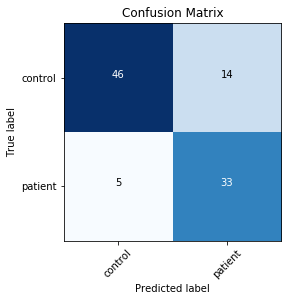

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69639
[0,   100] loss: 0.69267
Time elapsed: 0h:0m:15s
train accuracy_score: 51.27 %
train balanced_accuracy: 50.00 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.707886
[1,    50] loss: 0.69493
[1,   100] loss: 0.69344
Time elapsed: 0h:0m:32s
train accuracy_score: 50.85 %
train balanced_accuracy: 49.61 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.705678
[2,    50] loss: 0.69166
[2,   100] loss: 0.69453
Time elapsed: 0h:0m:49s
train accuracy_score: 51.55 %
train balanced_accuracy: 50.55 %
val accuracy_score: 74.49 %
val balanced_accuracy: 70.48 %
Val loss: 0.688580
[3,    50] loss: 0.68855
[3,   100] loss: 0.69421
Time elapsed: 0h:1m:7s
train accuracy_score: 53.67 %
train balanced_accuracy: 53.40 %
val accuracy_score: 73.47 %
val balanced_accuracy: 72.06 %
Val loss: 0.688147
[4,    50] 

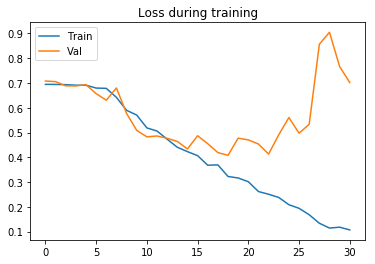

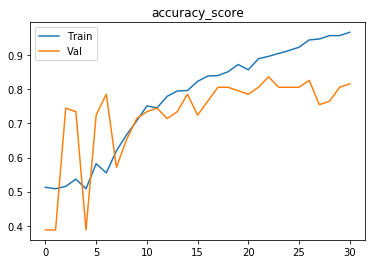

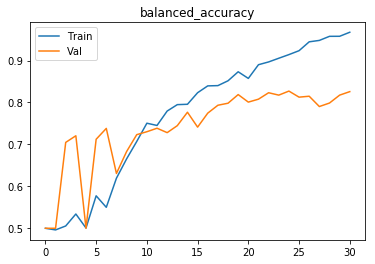

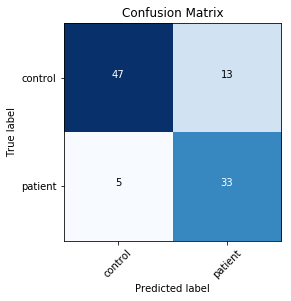

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69684
[0,   100] loss: 0.69272
[0,   150] loss: 0.69738
Time elapsed: 0h:0m:18s
train accuracy_score: 50.71 %
train balanced_accuracy: 50.39 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
Val loss: 0.687821
[1,    50] loss: 0.69230
[1,   100] loss: 0.69935
[1,   150] loss: 0.69775
Time elapsed: 0h:0m:38s
train accuracy_score: 49.72 %
train balanced_accuracy: 50.35 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.703315
[2,    50] loss: 0.69640
[2,   100] loss: 0.69283
[2,   150] loss: 0.69535
Time elapsed: 0h:0m:59s
train accuracy_score: 49.72 %
train balanced_accuracy: 48.70 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
Val loss: 0.690876
[3,    50] loss: 0.69571
[3,   100] loss: 0.69545
[3,   150] loss: 0.69453
Time elapsed: 0h:1m:19s
train accuracy_score: 50.99 %
train balanced_accura

val accuracy_score: 76.53 %
val balanced_accuracy: 76.97 %
Val loss: 0.724811
[34,    50] loss: 0.07790
[34,   100] loss: 0.10513
[34,   150] loss: 0.04802
Time elapsed: 0h:11m:50s
train accuracy_score: 97.46 %
train balanced_accuracy: 97.46 %
val accuracy_score: 80.61 %
val balanced_accuracy: 80.31 %
Val loss: 0.777479
[35,    50] loss: 0.06495
[35,   100] loss: 0.05248
[35,   150] loss: 0.05373
Time elapsed: 0h:12m:10s
train accuracy_score: 98.16 %
train balanced_accuracy: 98.17 %
val accuracy_score: 79.59 %
val balanced_accuracy: 81.40 %
Val loss: 0.864561
[36,    50] loss: 0.04071
[36,   100] loss: 0.06295
[36,   150] loss: 0.05499
Time elapsed: 0h:12m:31s
train accuracy_score: 98.02 %
train balanced_accuracy: 98.04 %
val accuracy_score: 80.61 %
val balanced_accuracy: 82.72 %
Val loss: 0.874348
Early stopping in epoch 37
Total time elapsed: 0h:12m:33s
Writing model to disk...
Best result during training: 0.83. Saving model..
Finished inner fold.


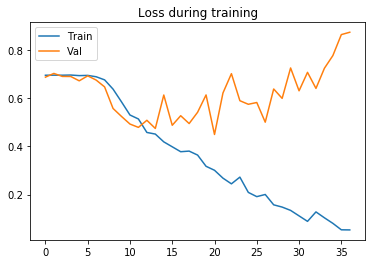

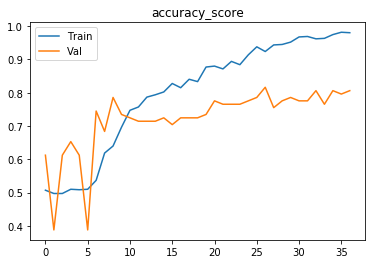

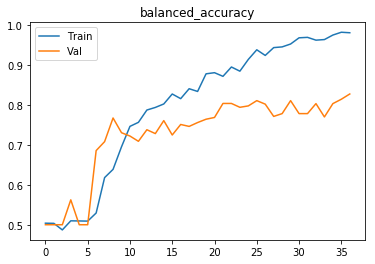

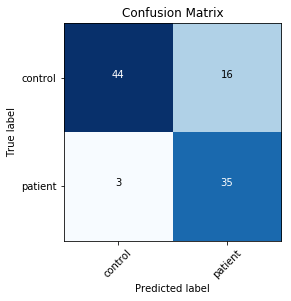

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69199
Time elapsed: 0h:0m:12s
train accuracy_score: 51.98 %
train balanced_accuracy: 51.84 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.722823
[1,    50] loss: 0.69449
Time elapsed: 0h:0m:26s
train accuracy_score: 49.44 %
train balanced_accuracy: 49.28 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.702378
[2,    50] loss: 0.69273
Time elapsed: 0h:0m:41s
train accuracy_score: 51.98 %
train balanced_accuracy: 50.30 %
val accuracy_score: 38.78 %
val balanced_accuracy: 50.00 %
Val loss: 0.694141
[3,    50] loss: 0.69266
Time elapsed: 0h:0m:56s
train accuracy_score: 51.69 %
train balanced_accuracy: 50.39 %
val accuracy_score: 78.57 %
val balanced_accuracy: 76.71 %
Val loss: 0.691234
[4,    50] loss: 0.69105
Time elapsed: 0h:1m:10s
train accuracy_score: 54.38 %
train balanced_accuracy: 54.51

val accuracy_score: 88.78 %
val balanced_accuracy: 88.42 %
Val loss: 0.404647
[43,    50] loss: 0.08188
Time elapsed: 0h:10m:36s
train accuracy_score: 97.46 %
train balanced_accuracy: 97.45 %
val accuracy_score: 77.55 %
val balanced_accuracy: 80.70 %
Val loss: 0.692584
[44,    50] loss: 0.07671
Time elapsed: 0h:10m:51s
train accuracy_score: 97.60 %
train balanced_accuracy: 97.60 %
val accuracy_score: 87.76 %
val balanced_accuracy: 87.59 %
Val loss: 0.423619
[45,    50] loss: 0.06441
Time elapsed: 0h:11m:5s
train accuracy_score: 98.16 %
train balanced_accuracy: 98.20 %
val accuracy_score: 81.63 %
val balanced_accuracy: 83.55 %
Val loss: 0.512184
[46,    50] loss: 0.07628
Time elapsed: 0h:11m:20s
train accuracy_score: 97.18 %
train balanced_accuracy: 97.17 %
val accuracy_score: 79.59 %
val balanced_accuracy: 81.89 %
Val loss: 0.570287
Early stopping in epoch 47
Total time elapsed: 0h:11m:22s
Writing model to disk...
Best result during training: 0.88. Saving model..
Finished inner fold.


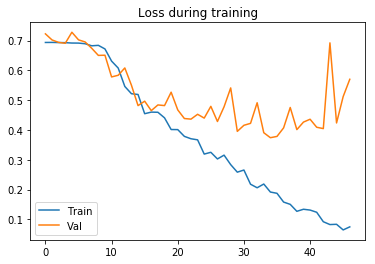

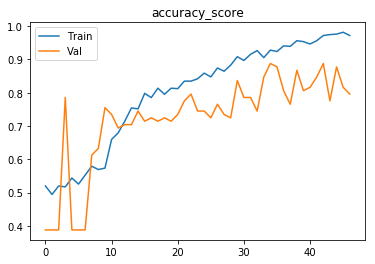

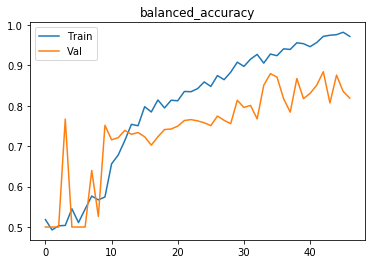

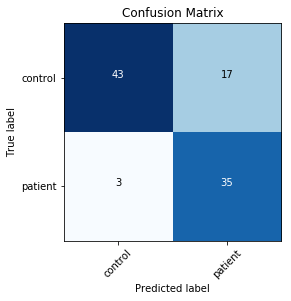

Finished outer fold.
{'final_acc': 0.8188596491228072, 'best_acc': 0.8842105263157896, 'final_iter': 47, 'best_iter': 43, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}
###### Starting outer fold 4
# of patients 402, # of healthy controls 398
696
104
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69380
Time elapsed: 0h:0m:7s
train accuracy_score: 49.14 %
train balanced_accuracy: 49.61 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.694086
[1,    50] loss: 0.69311
Time elapsed: 0h:0m:17s
train accuracy_score: 51.44 %
train balanced_accuracy: 50.57 %
val accuracy_score: 51.92 %
val balanced_accuracy: 56.14 %
Val loss: 0.692898
[2,    50] loss: 0.69245
Time elapsed: 0h:0m:26s
train accuracy_score: 53.74 %
train balanced_accuracy: 53.59 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.88 %
Val loss: 0.6925

[41,    50] loss: 0.42387
Time elapsed: 0h:6m:38s
train accuracy_score: 80.32 %
train balanced_accuracy: 80.35 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.77 %
Val loss: 0.493245
[42,    50] loss: 0.40894
Time elapsed: 0h:6m:47s
train accuracy_score: 81.61 %
train balanced_accuracy: 81.58 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.14 %
Val loss: 0.490344
[43,    50] loss: 0.38846
Time elapsed: 0h:6m:55s
train accuracy_score: 81.75 %
train balanced_accuracy: 81.73 %
val accuracy_score: 75.96 %
val balanced_accuracy: 76.76 %
Val loss: 0.522764
[44,    50] loss: 0.39399
Time elapsed: 0h:7m:4s
train accuracy_score: 83.48 %
train balanced_accuracy: 83.50 %
val accuracy_score: 78.85 %
val balanced_accuracy: 79.40 %
Val loss: 0.509424
[45,    50] loss: 0.39484
Time elapsed: 0h:7m:13s
train accuracy_score: 82.18 %
train balanced_accuracy: 82.17 %
val accuracy_score: 75.00 %
val balanced_accuracy: 76.07 %
Val loss: 0.539182
[46,    50] loss: 0.42546
Time elapsed: 0h:7m:

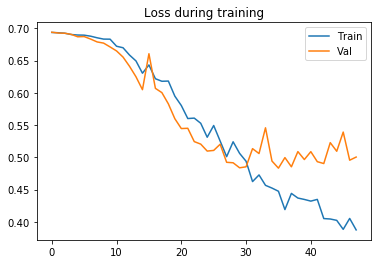

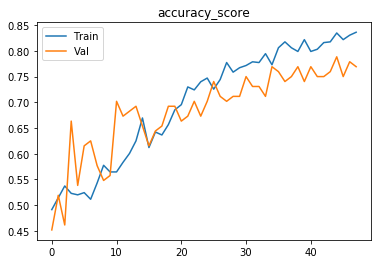

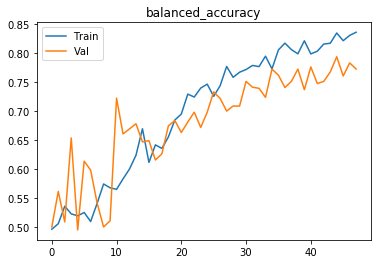

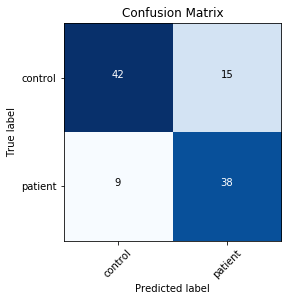

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69988
[0,   100] loss: 0.69751
[0,   150] loss: 0.69909
Time elapsed: 0h:0m:11s
train accuracy_score: 45.69 %
train balanced_accuracy: 46.15 %
val accuracy_score: 47.12 %
val balanced_accuracy: 51.75 %
Val loss: 0.692908
[1,    50] loss: 0.69313
[1,   100] loss: 0.69712
[1,   150] loss: 0.69815
Time elapsed: 0h:0m:23s
train accuracy_score: 47.13 %
train balanced_accuracy: 47.42 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.689712
[2,    50] loss: 0.68987
[2,   100] loss: 0.69763
[2,   150] loss: 0.69520
Time elapsed: 0h:0m:36s
train accuracy_score: 52.44 %
train balanced_accuracy: 52.49 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.697434
[3,    50] loss: 0.70177
[3,   100] loss: 0.69267
[3,   150] loss: 0.69753
Time elapsed: 0h:0m:49s
train accuracy_score: 50.72 %
train balanced_accur

val accuracy_score: 83.65 %
val balanced_accuracy: 84.90 %
Val loss: 0.496956
[34,    50] loss: 0.16032
[34,   100] loss: 0.18025
[34,   150] loss: 0.13511
Time elapsed: 0h:7m:26s
train accuracy_score: 93.97 %
train balanced_accuracy: 93.98 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.85 %
Val loss: 0.369910
[35,    50] loss: 0.12012
[35,   100] loss: 0.14667
[35,   150] loss: 0.21994
Time elapsed: 0h:7m:39s
train accuracy_score: 93.82 %
train balanced_accuracy: 93.83 %
val accuracy_score: 85.58 %
val balanced_accuracy: 86.28 %
Val loss: 0.409526
[36,    50] loss: 0.17446
[36,   100] loss: 0.10076
[36,   150] loss: 0.12770
Time elapsed: 0h:7m:51s
train accuracy_score: 95.26 %
train balanced_accuracy: 95.29 %
val accuracy_score: 85.58 %
val balanced_accuracy: 86.66 %
Val loss: 0.507190
[37,    50] loss: 0.14961
[37,   100] loss: 0.14750
[37,   150] loss: 0.11459
Time elapsed: 0h:8m:4s
train accuracy_score: 94.68 %
train balanced_accuracy: 94.69 %
val accuracy_score: 84.62 %
v

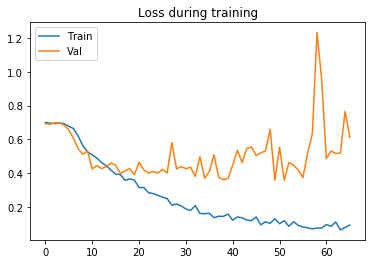

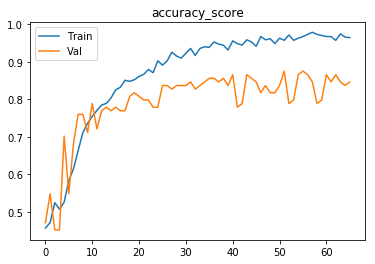

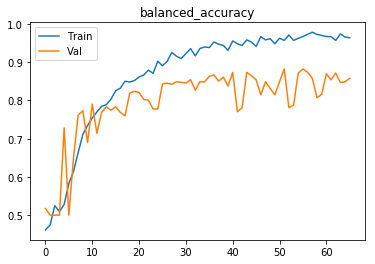

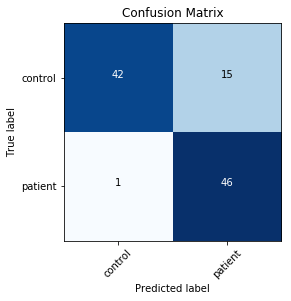

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69587
[0,   100] loss: 0.69616
[0,   150] loss: 0.69562
Time elapsed: 0h:0m:17s
train accuracy_score: 49.57 %
train balanced_accuracy: 49.62 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.700311
[1,    50] loss: 0.69006
[1,   100] loss: 0.69582
[1,   150] loss: 0.70029
Time elapsed: 0h:0m:36s
train accuracy_score: 52.73 %
train balanced_accuracy: 52.59 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.696130
[2,    50] loss: 0.68628
[2,   100] loss: 0.69346
[2,   150] loss: 0.69511
Time elapsed: 0h:0m:56s
train accuracy_score: 53.30 %
train balanced_accuracy: 53.42 %
val accuracy_score: 60.58 %
val balanced_accuracy: 56.57 %
Val loss: 0.682757
[3,    50] loss: 0.69188
[3,   100] loss: 0.69366
[3,   150] loss: 0.68585
Time elapsed: 0h:1m:15s
train accuracy_score: 52.73 %
train balanced_accura

Time elapsed: 0h:11m:10s
train accuracy_score: 97.13 %
train balanced_accuracy: 97.13 %
val accuracy_score: 83.65 %
val balanced_accuracy: 83.78 %
Val loss: 0.596463
[34,    50] loss: 0.07045
[34,   100] loss: 0.03858
[34,   150] loss: 0.06870
Time elapsed: 0h:11m:29s
train accuracy_score: 98.42 %
train balanced_accuracy: 98.42 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.22 %
Val loss: 0.632683
[35,    50] loss: 0.03627
[35,   100] loss: 0.06252
[35,   150] loss: 0.06254
Time elapsed: 0h:11m:49s
train accuracy_score: 97.70 %
train balanced_accuracy: 97.70 %
val accuracy_score: 83.65 %
val balanced_accuracy: 83.22 %
Val loss: 0.562194
[36,    50] loss: 0.07144
[36,   100] loss: 0.03434
[36,   150] loss: 0.05127
Time elapsed: 0h:12m:9s
train accuracy_score: 98.13 %
train balanced_accuracy: 98.14 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.29 %
Val loss: 0.544220
[37,    50] loss: 0.07603
[37,   100] loss: 0.06491
[37,   150] loss: 0.02384
Time elapsed: 0h:12m:29s


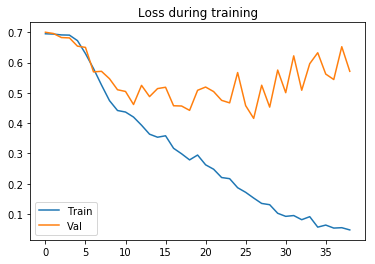

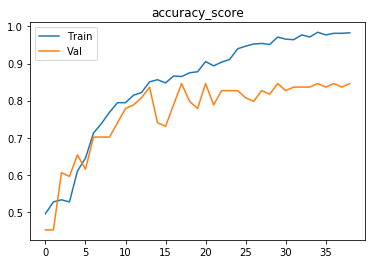

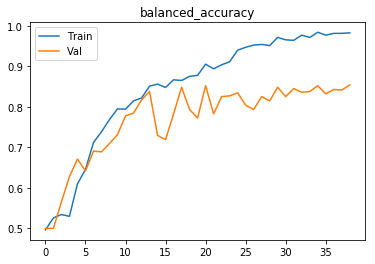

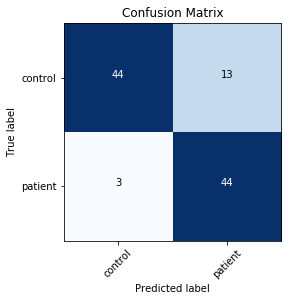

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69828
[0,   100] loss: 0.70189
Time elapsed: 0h:0m:14s
train accuracy_score: 47.84 %
train balanced_accuracy: 48.10 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.691448
[1,    50] loss: 0.69916
[1,   100] loss: 0.69669
Time elapsed: 0h:0m:31s
train accuracy_score: 47.99 %
train balanced_accuracy: 48.46 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
Val loss: 0.691644
[2,    50] loss: 0.69668
[2,   100] loss: 0.69716
Time elapsed: 0h:0m:48s
train accuracy_score: 47.70 %
train balanced_accuracy: 47.76 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.701115
[3,    50] loss: 0.69874
[3,   100] loss: 0.69444
Time elapsed: 0h:1m:5s
train accuracy_score: 47.56 %
train balanced_accuracy: 47.57 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.693954
[4,    50]

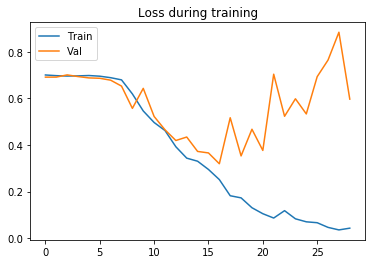

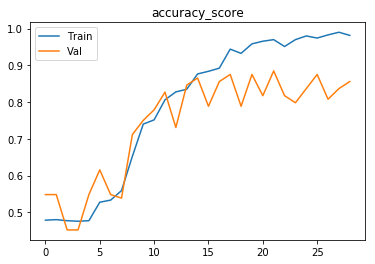

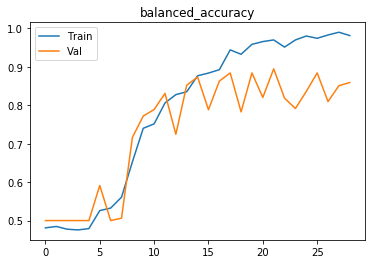

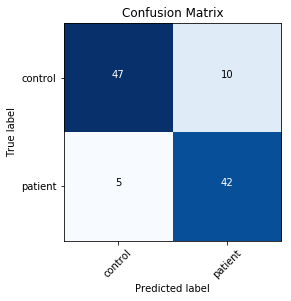

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69753
[0,   100] loss: 0.70013
Time elapsed: 0h:0m:14s
train accuracy_score: 50.72 %
train balanced_accuracy: 50.56 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.702785
[1,    50] loss: 0.69935
[1,   100] loss: 0.69373
Time elapsed: 0h:0m:32s
train accuracy_score: 48.42 %
train balanced_accuracy: 48.71 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
Val loss: 0.722105
[2,    50] loss: 0.69952
[2,   100] loss: 0.69526
Time elapsed: 0h:0m:49s
train accuracy_score: 47.13 %
train balanced_accuracy: 46.78 %
val accuracy_score: 59.62 %
val balanced_accuracy: 55.32 %
Val loss: 0.690914
[3,    50] loss: 0.69442
[3,   100] loss: 0.69399
Time elapsed: 0h:1m:6s
train accuracy_score: 49.14 %
train balanced_accuracy: 49.15 %
val accuracy_score: 64.42 %
val balanced_accuracy: 63.44 %
Val loss: 0.689113
[4,    50]

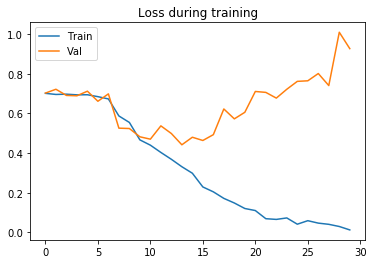

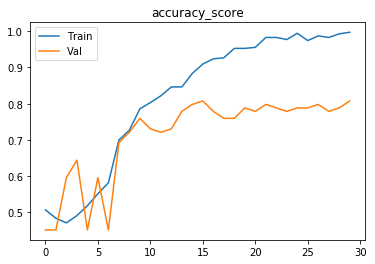

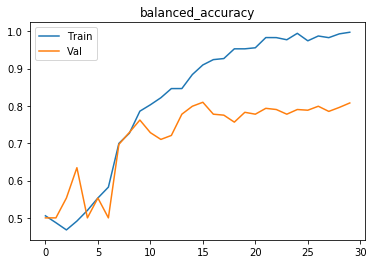

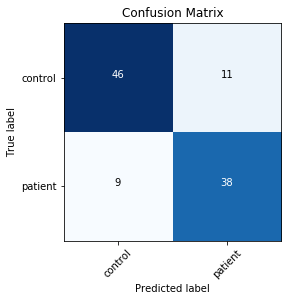

Finished outer fold.
{'final_acc': 0.8577827547592385, 'best_acc': 0.8822321761851437, 'final_iter': 66, 'best_iter': 56, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 5
# of patients 402, # of healthy controls 397
684
115
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69549
[0,   100] loss: 0.69852
[0,   150] loss: 0.69184
Time elapsed: 0h:0m:11s
train accuracy_score: 54.53 %
train balanced_accuracy: 54.34 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.701032
[1,    50] loss: 0.69690
[1,   100] loss: 0.69410
[1,   150] loss: 0.69975
Time elapsed: 0h:0m:24s
train accuracy_score: 48.98 %
train balanced_accuracy: 48.72 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.697717
[2,    50] loss: 0.69456
[2,   100] loss: 0.69495
[2,   150] loss: 0.69632
Time elapse

[32,   100] loss: 0.23604
[32,   150] loss: 0.22678
Time elapsed: 0h:7m:18s
train accuracy_score: 89.04 %
train balanced_accuracy: 89.04 %
val accuracy_score: 88.70 %
val balanced_accuracy: 88.31 %
Val loss: 0.289982
[33,    50] loss: 0.23013
[33,   100] loss: 0.21518
[33,   150] loss: 0.22799
Time elapsed: 0h:7m:32s
train accuracy_score: 89.33 %
train balanced_accuracy: 89.31 %
val accuracy_score: 86.96 %
val balanced_accuracy: 85.75 %
Val loss: 0.297934
[34,    50] loss: 0.21185
[34,   100] loss: 0.17310
[34,   150] loss: 0.22033
Time elapsed: 0h:7m:45s
train accuracy_score: 91.52 %
train balanced_accuracy: 91.53 %
val accuracy_score: 83.48 %
val balanced_accuracy: 84.29 %
Val loss: 0.381591
[35,    50] loss: 0.22820
[35,   100] loss: 0.20443
[35,   150] loss: 0.19029
Time elapsed: 0h:7m:58s
train accuracy_score: 91.23 %
train balanced_accuracy: 91.23 %
val accuracy_score: 85.22 %
val balanced_accuracy: 83.44 %
Val loss: 0.391830
[36,    50] loss: 0.17579
[36,   100] loss: 0.19433
[3

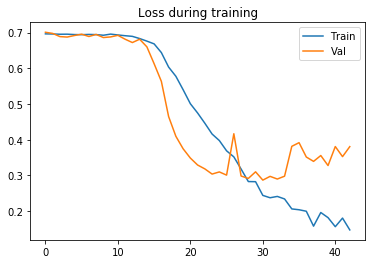

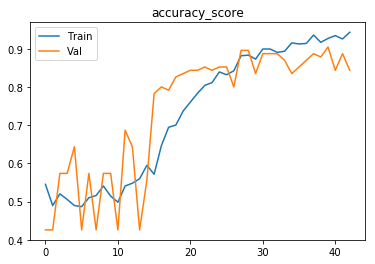

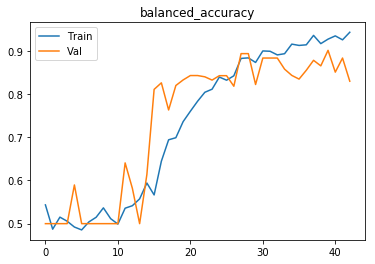

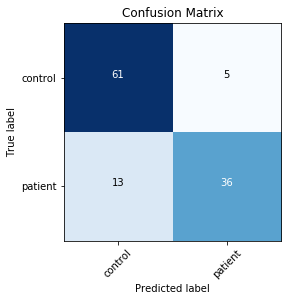

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69380
Time elapsed: 0h:0m:7s
train accuracy_score: 52.34 %
train balanced_accuracy: 51.13 %
val accuracy_score: 57.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.687817
[1,    50] loss: 0.69575
Time elapsed: 0h:0m:16s
train accuracy_score: 47.37 %
train balanced_accuracy: 47.50 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.698535
[2,    50] loss: 0.69588
Time elapsed: 0h:0m:25s
train accuracy_score: 50.88 %
train balanced_accuracy: 50.20 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.696842
[3,    50] loss: 0.69312
Time elapsed: 0h:0m:34s
train accuracy_score: 52.49 %
train balanced_accuracy: 52.16 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.695678
[4,    50] loss: 0.69423
Time elapsed: 0h:0m:43s
train accuracy_score: 53.22 %
train balanced_accuracy: 52.76

val accuracy_score: 87.83 %
val balanced_accuracy: 88.87 %
Val loss: 0.267458
[43,    50] loss: 0.31579
Time elapsed: 0h:6m:46s
train accuracy_score: 87.57 %
train balanced_accuracy: 87.60 %
val accuracy_score: 85.22 %
val balanced_accuracy: 85.54 %
Val loss: 0.262374
[44,    50] loss: 0.33564
Time elapsed: 0h:6m:55s
train accuracy_score: 85.09 %
train balanced_accuracy: 85.10 %
val accuracy_score: 89.57 %
val balanced_accuracy: 89.33 %
Val loss: 0.236482
[45,    50] loss: 0.30364
Time elapsed: 0h:7m:4s
train accuracy_score: 86.70 %
train balanced_accuracy: 86.73 %
val accuracy_score: 87.83 %
val balanced_accuracy: 87.29 %
Val loss: 0.246625
[46,    50] loss: 0.30720
Time elapsed: 0h:7m:13s
train accuracy_score: 85.96 %
train balanced_accuracy: 86.04 %
val accuracy_score: 80.00 %
val balanced_accuracy: 82.58 %
Val loss: 0.513797
[47,    50] loss: 0.28785
Time elapsed: 0h:7m:23s
train accuracy_score: 86.84 %
train balanced_accuracy: 86.86 %
val accuracy_score: 87.83 %
val balanced_accur

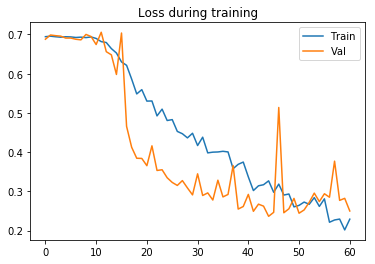

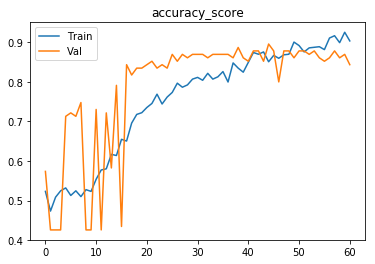

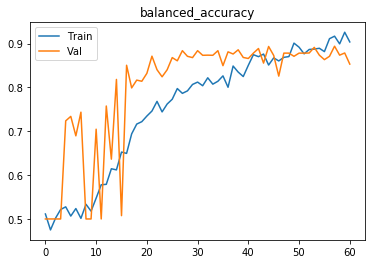

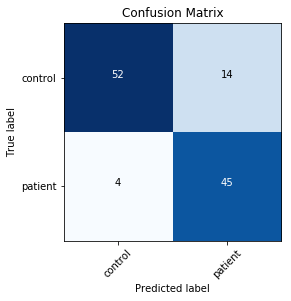

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69474
[0,   100] loss: 0.70447
[0,   150] loss: 0.69997
Time elapsed: 0h:0m:17s
train accuracy_score: 48.83 %
train balanced_accuracy: 48.26 %
val accuracy_score: 57.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.686371
[1,    50] loss: 0.70110
[1,   100] loss: 0.69751
[1,   150] loss: 0.70221
Time elapsed: 0h:0m:37s
train accuracy_score: 46.78 %
train balanced_accuracy: 46.45 %
val accuracy_score: 57.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.686584
[2,    50] loss: 0.69735
[2,   100] loss: 0.70192
[2,   150] loss: 0.70021
Time elapsed: 0h:0m:57s
train accuracy_score: 49.27 %
train balanced_accuracy: 48.96 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.799444
[3,    50] loss: 0.70453
[3,   100] loss: 0.69827
[3,   150] loss: 0.69616
Time elapsed: 0h:1m:17s
train accuracy_score: 49.12 %
train balanced_accur

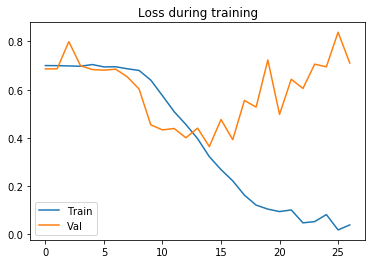

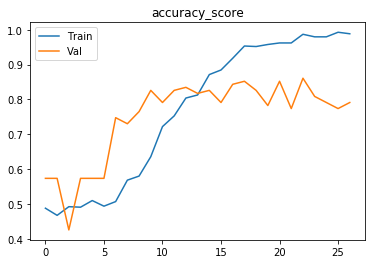

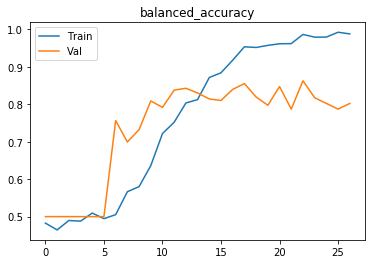

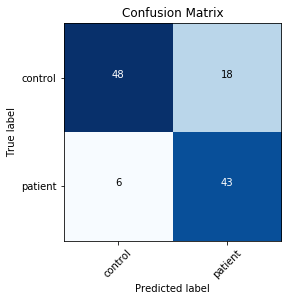

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69471
Time elapsed: 0h:0m:11s
train accuracy_score: 51.02 %
train balanced_accuracy: 49.79 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.696058
[1,    50] loss: 0.69412
Time elapsed: 0h:0m:26s
train accuracy_score: 49.27 %
train balanced_accuracy: 48.03 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.693848
[2,    50] loss: 0.69410
Time elapsed: 0h:0m:40s
train accuracy_score: 52.63 %
train balanced_accuracy: 51.69 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.702130
[3,    50] loss: 0.69396
Time elapsed: 0h:0m:55s
train accuracy_score: 51.61 %
train balanced_accuracy: 50.01 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.693262
[4,    50] loss: 0.69246
Time elapsed: 0h:1m:9s
train accuracy_score: 51.02 %
train balanced_accuracy: 50.85 

val accuracy_score: 80.00 %
val balanced_accuracy: 80.21 %
Val loss: 0.482818
[43,    50] loss: 0.09155
Time elapsed: 0h:10m:36s
train accuracy_score: 97.37 %
train balanced_accuracy: 97.39 %
val accuracy_score: 79.13 %
val balanced_accuracy: 81.82 %
Val loss: 0.696631
Early stopping in epoch 44
Total time elapsed: 0h:10m:39s
Writing model to disk...
Best result during training: 0.84. Saving model..
Finished inner fold.


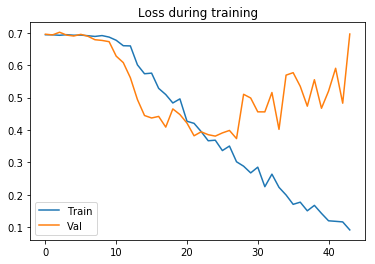

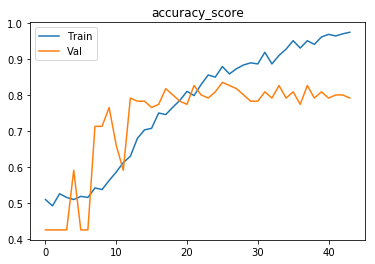

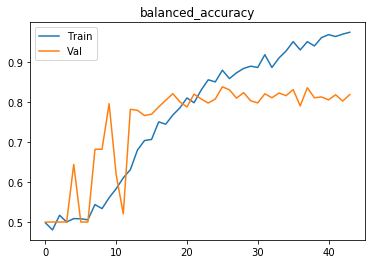

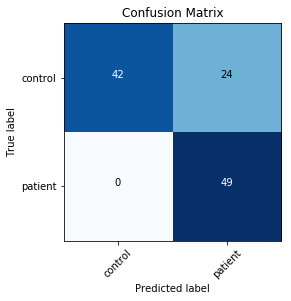

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69485
Time elapsed: 0h:0m:7s
train accuracy_score: 49.42 %
train balanced_accuracy: 49.63 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.695029
[1,    50] loss: 0.69346
Time elapsed: 0h:0m:16s
train accuracy_score: 52.05 %
train balanced_accuracy: 51.32 %
val accuracy_score: 57.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.691352
[2,    50] loss: 0.69424
Time elapsed: 0h:0m:26s
train accuracy_score: 50.29 %
train balanced_accuracy: 49.52 %
val accuracy_score: 45.22 %
val balanced_accuracy: 51.75 %
Val loss: 0.693323
[3,    50] loss: 0.69412
Time elapsed: 0h:0m:35s
train accuracy_score: 50.15 %
train balanced_accuracy: 50.82 %
val accuracy_score: 46.09 %
val balanced_accuracy: 53.03 %
Val loss: 0.692910
[4,    50] loss: 0.69251
Time elapsed: 0h:0m:45s
train accuracy_score: 50.29 %
train balanced_accuracy: 49.05 

val accuracy_score: 82.61 %
val balanced_accuracy: 82.48 %
Val loss: 0.320943
[43,    50] loss: 0.34717
Time elapsed: 0h:6m:50s
train accuracy_score: 84.50 %
train balanced_accuracy: 84.49 %
val accuracy_score: 81.74 %
val balanced_accuracy: 80.94 %
Val loss: 0.312215
[44,    50] loss: 0.35563
Time elapsed: 0h:6m:59s
train accuracy_score: 84.94 %
train balanced_accuracy: 84.93 %
val accuracy_score: 84.35 %
val balanced_accuracy: 85.84 %
Val loss: 0.363879
[45,    50] loss: 0.34735
Time elapsed: 0h:7m:8s
train accuracy_score: 86.11 %
train balanced_accuracy: 86.09 %
val accuracy_score: 85.22 %
val balanced_accuracy: 86.60 %
Val loss: 0.364110
[46,    50] loss: 0.34582
Time elapsed: 0h:7m:18s
train accuracy_score: 85.67 %
train balanced_accuracy: 85.67 %
val accuracy_score: 81.74 %
val balanced_accuracy: 80.94 %
Val loss: 0.304821
[47,    50] loss: 0.32286
Time elapsed: 0h:7m:27s
train accuracy_score: 84.36 %
train balanced_accuracy: 84.42 %
val accuracy_score: 85.22 %
val balanced_accur

val accuracy_score: 88.70 %
val balanced_accuracy: 89.10 %
Val loss: 0.268707
[86,    50] loss: 0.20046
Time elapsed: 0h:13m:32s
train accuracy_score: 89.77 %
train balanced_accuracy: 89.77 %
val accuracy_score: 89.57 %
val balanced_accuracy: 89.59 %
Val loss: 0.227421
[87,    50] loss: 0.19096
Time elapsed: 0h:13m:41s
train accuracy_score: 92.54 %
train balanced_accuracy: 92.60 %
val accuracy_score: 73.91 %
val balanced_accuracy: 77.01 %
Val loss: 0.466239
[88,    50] loss: 0.19502
Time elapsed: 0h:13m:51s
train accuracy_score: 92.84 %
train balanced_accuracy: 92.80 %
val accuracy_score: 90.43 %
val balanced_accuracy: 89.04 %
Val loss: 0.220454
[89,    50] loss: 0.18467
Time elapsed: 0h:14m:0s
train accuracy_score: 92.25 %
train balanced_accuracy: 92.30 %
val accuracy_score: 90.43 %
val balanced_accuracy: 90.09 %
Val loss: 0.208036
[90,    50] loss: 0.16268
Time elapsed: 0h:14m:10s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.41 %
val accuracy_score: 88.70 %
val balanced_

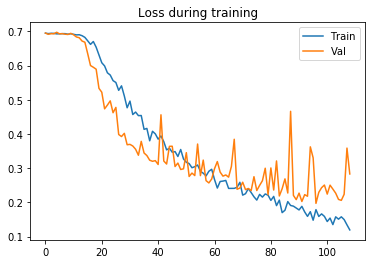

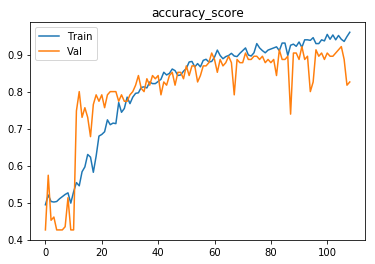

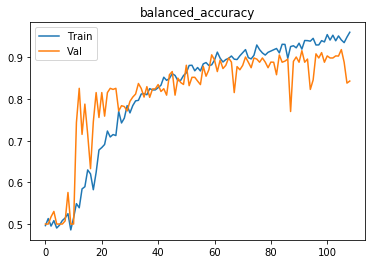

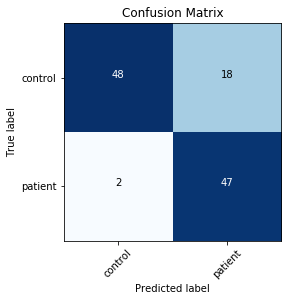

Finished outer fold.
{'final_acc': 0.8432282003710575, 'best_acc': 0.9186765615337045, 'final_iter': 109, 'best_iter': 106, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}
###### Starting outer fold 6
# of patients 407, # of healthy controls 404
708
103
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69672
[0,   100] loss: 0.69571
Time elapsed: 0h:0m:9s
train accuracy_score: 49.44 %
train balanced_accuracy: 49.48 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.701896
[1,    50] loss: 0.69465
[1,   100] loss: 0.69486
Time elapsed: 0h:0m:20s
train accuracy_score: 52.26 %
train balanced_accuracy: 51.40 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.679855
[2,    50] loss: 0.69342
[2,   100] loss: 0.69657
Time elapsed: 0h:0m:32s
train accuracy_score: 52.40 %
train balanced_accuracy: 52.45 

[36,    50] loss: 0.17245
[36,   100] loss: 0.19585
Time elapsed: 0h:6m:53s
train accuracy_score: 92.37 %
train balanced_accuracy: 92.42 %
val accuracy_score: 82.52 %
val balanced_accuracy: 82.98 %
Val loss: 0.456530
[37,    50] loss: 0.17717
[37,   100] loss: 0.15742
Time elapsed: 0h:7m:4s
train accuracy_score: 92.09 %
train balanced_accuracy: 92.12 %
val accuracy_score: 84.47 %
val balanced_accuracy: 85.93 %
Val loss: 0.568119
[38,    50] loss: 0.17174
[38,   100] loss: 0.18007
Time elapsed: 0h:7m:15s
train accuracy_score: 92.66 %
train balanced_accuracy: 92.68 %
val accuracy_score: 78.64 %
val balanced_accuracy: 82.54 %
Val loss: 0.710530
[39,    50] loss: 0.21999
[39,   100] loss: 0.13555
Time elapsed: 0h:7m:26s
train accuracy_score: 92.66 %
train balanced_accuracy: 92.68 %
val accuracy_score: 71.84 %
val balanced_accuracy: 76.98 %
Val loss: 0.947647
[40,    50] loss: 0.22077
[40,   100] loss: 0.18248
Time elapsed: 0h:7m:37s
train accuracy_score: 91.10 %
train balanced_accuracy: 91

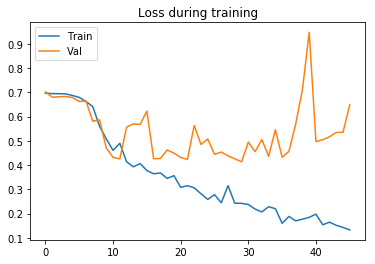

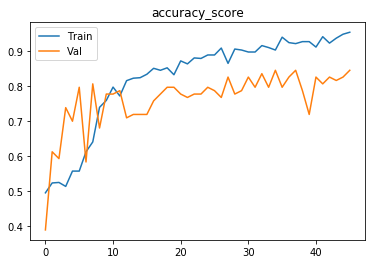

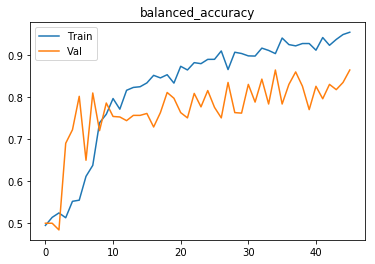

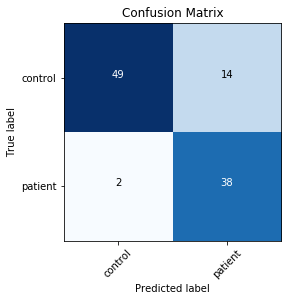

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69119
[0,   100] loss: 0.69868
[0,   150] loss: 0.69316
Time elapsed: 0h:0m:11s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.87 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.700687
[1,    50] loss: 0.69430
[1,   100] loss: 0.69331
[1,   150] loss: 0.68925
Time elapsed: 0h:0m:25s
train accuracy_score: 51.55 %
train balanced_accuracy: 49.81 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.701901
[2,    50] loss: 0.69361
[2,   100] loss: 0.68705
[2,   150] loss: 0.69523
Time elapsed: 0h:0m:38s
train accuracy_score: 51.84 %
train balanced_accuracy: 51.09 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.699585
[3,    50] loss: 0.68676
[3,   100] loss: 0.69012
[3,   150] loss: 0.68679
Time elapsed: 0h:0m:52s
train accuracy_score: 52.68 %
train balanced_accura

val accuracy_score: 70.87 %
val balanced_accuracy: 74.82 %
Val loss: 0.604565
[34,    50] loss: 0.32438
[34,   100] loss: 0.26314
[34,   150] loss: 0.26960
Time elapsed: 0h:7m:49s
train accuracy_score: 86.86 %
train balanced_accuracy: 86.95 %
val accuracy_score: 70.87 %
val balanced_accuracy: 74.82 %
Val loss: 0.624469
[35,    50] loss: 0.28365
[35,   100] loss: 0.25267
[35,   150] loss: 0.24804
Time elapsed: 0h:8m:2s
train accuracy_score: 88.84 %
train balanced_accuracy: 88.94 %
val accuracy_score: 76.70 %
val balanced_accuracy: 77.30 %
Val loss: 0.485622
[36,    50] loss: 0.25751
[36,   100] loss: 0.26383
[36,   150] loss: 0.30136
Time elapsed: 0h:8m:16s
train accuracy_score: 87.43 %
train balanced_accuracy: 87.56 %
val accuracy_score: 75.73 %
val balanced_accuracy: 76.96 %
Val loss: 0.494401
Early stopping in epoch 37
Total time elapsed: 0h:8m:18s
Writing model to disk...
Best result during training: 0.81. Saving model..
Finished inner fold.


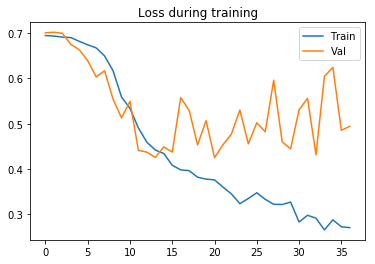

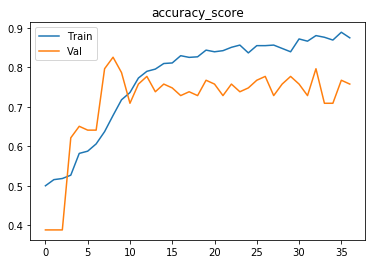

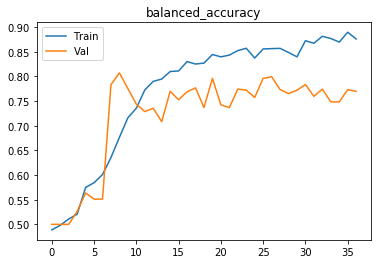

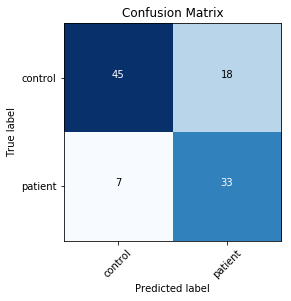

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.69421
[0,   100] loss: 0.69483
Time elapsed: 0h:0m:15s
train accuracy_score: 49.58 %
train balanced_accuracy: 49.03 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.687125
[1,    50] loss: 0.69789
[1,   100] loss: 0.69027
Time elapsed: 0h:0m:32s
train accuracy_score: 50.85 %
train balanced_accuracy: 50.01 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.709897
[2,    50] loss: 0.69682
[2,   100] loss: 0.69912
Time elapsed: 0h:0m:49s
train accuracy_score: 50.85 %
train balanced_accuracy: 50.45 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.710179
[3,    50] loss: 0.68950
[3,   100] loss: 0.69729
Time elapsed: 0h:1m:7s
train accuracy_score: 51.55 %
train balanced_accuracy: 50.92 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.670790
[4,    50]

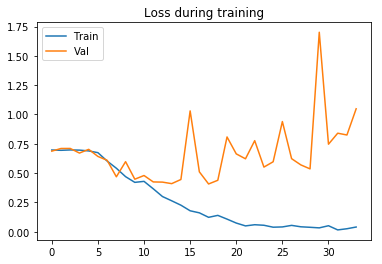

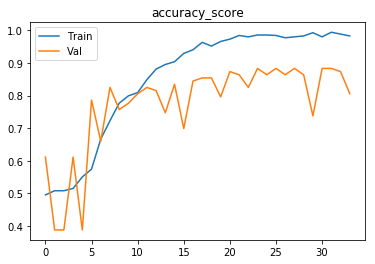

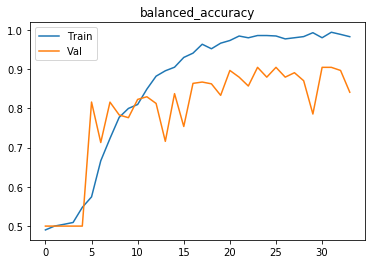

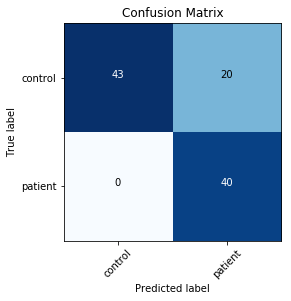

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69533
Time elapsed: 0h:0m:12s
train accuracy_score: 49.29 %
train balanced_accuracy: 48.53 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.693603
[1,    50] loss: 0.69150
Time elapsed: 0h:0m:27s
train accuracy_score: 54.52 %
train balanced_accuracy: 53.74 %
val accuracy_score: 59.22 %
val balanced_accuracy: 48.87 %
Val loss: 0.687069
[2,    50] loss: 0.69413
Time elapsed: 0h:0m:41s
train accuracy_score: 49.58 %
train balanced_accuracy: 49.15 %
val accuracy_score: 64.08 %
val balanced_accuracy: 55.12 %
Val loss: 0.689055
[3,    50] loss: 0.69283
Time elapsed: 0h:0m:56s
train accuracy_score: 51.84 %
train balanced_accuracy: 51.82 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
Val loss: 0.702439
[4,    50] loss: 0.69380
Time elapsed: 0h:1m:10s
train accuracy_score: 52.12 %
train balanced_accuracy: 51.32

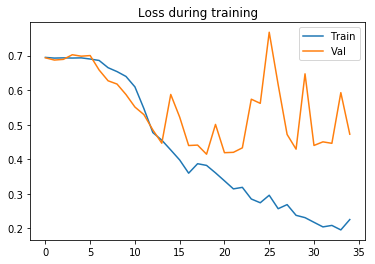

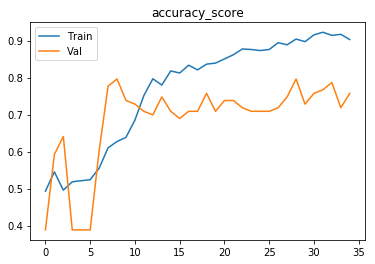

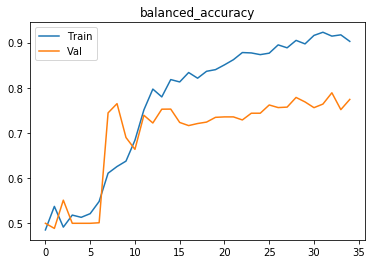

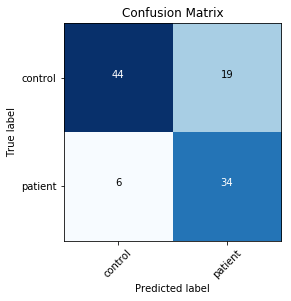

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    50] loss: 0.70011
[0,   100] loss: 0.69820
[0,   150] loss: 0.69854
Time elapsed: 0h:0m:18s
train accuracy_score: 50.85 %
train balanced_accuracy: 50.44 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.665405
[1,    50] loss: 0.70315
[1,   100] loss: 0.70115
[1,   150] loss: 0.69678
Time elapsed: 0h:0m:39s
train accuracy_score: 47.74 %
train balanced_accuracy: 47.22 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
Val loss: 0.681969
[2,    50] loss: 0.69414
[2,   100] loss: 0.69742
[2,   150] loss: 0.69686
Time elapsed: 0h:1m:0s
train accuracy_score: 51.41 %
train balanced_accuracy: 51.70 %
val accuracy_score: 60.19 %
val balanced_accuracy: 50.58 %
Val loss: 0.687656
[3,    50] loss: 0.69652
[3,   100] loss: 0.68941
[3,   150] loss: 0.69275
Time elapsed: 0h:1m:20s
train accuracy_score: 55.93 %
train balanced_accura

Time elapsed: 0h:11m:35s
train accuracy_score: 98.87 %
train balanced_accuracy: 98.86 %
val accuracy_score: 84.47 %
val balanced_accuracy: 85.02 %
Val loss: 0.712747
Early stopping in epoch 34
Total time elapsed: 0h:11m:37s
Writing model to disk...
Best result during training: 0.90. Saving model..
Finished inner fold.


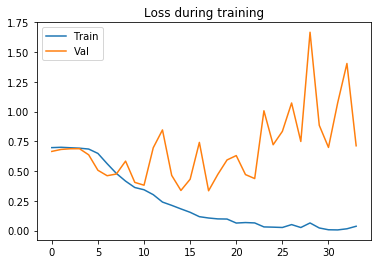

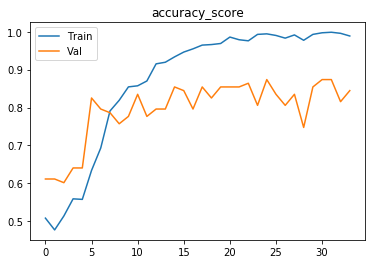

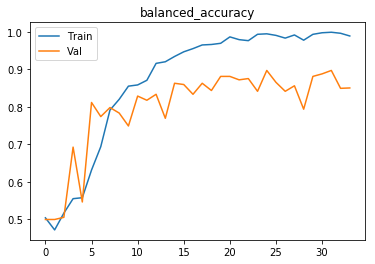

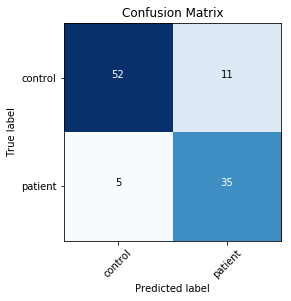

Finished outer fold.
{'final_acc': 0.8501984126984127, 'best_acc': 0.8968253968253966, 'final_iter': 34, 'best_iter': 32, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}
###### Starting outer fold 7
# of patients 401, # of healthy controls 395
702
94
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69299
[0,   100] loss: 0.69769
Time elapsed: 0h:0m:9s
train accuracy_score: 51.71 %
train balanced_accuracy: 51.09 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.699597
[1,    50] loss: 0.69683
[1,   100] loss: 0.69353
Time elapsed: 0h:0m:20s
train accuracy_score: 51.57 %
train balanced_accuracy: 51.16 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.706327
[2,    50] loss: 0.69224
[2,   100] loss: 0.69488
Time elapsed: 0h:0m:31s
train accuracy_score: 50.71 %
train balanced_accuracy: 49.91 %
v

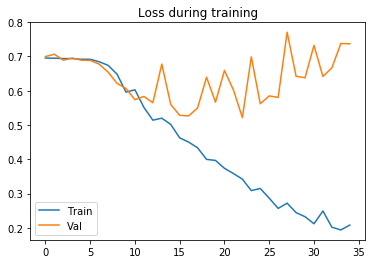

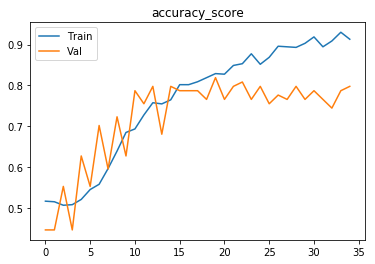

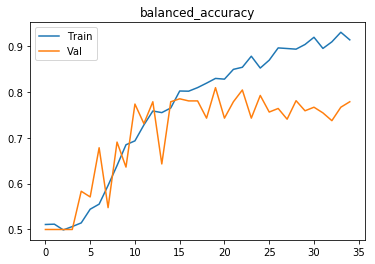

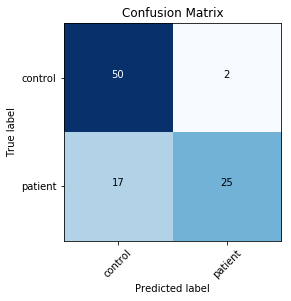

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69396
Time elapsed: 0h:0m:7s
train accuracy_score: 50.14 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.690444
[1,    50] loss: 0.69751
Time elapsed: 0h:0m:16s
train accuracy_score: 50.00 %
train balanced_accuracy: 50.63 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.694783
[2,    50] loss: 0.69526
Time elapsed: 0h:0m:26s
train accuracy_score: 48.43 %
train balanced_accuracy: 48.45 %
val accuracy_score: 62.77 %
val balanced_accuracy: 60.62 %
Val loss: 0.692053
[3,    50] loss: 0.69321
Time elapsed: 0h:0m:35s
train accuracy_score: 52.56 %
train balanced_accuracy: 52.38 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.690059
[4,    50] loss: 0.69535
Time elapsed: 0h:0m:44s
train accuracy_score: 49.86 %
train balanced_accuracy: 49.78

val accuracy_score: 77.66 %
val balanced_accuracy: 76.83 %
Val loss: 0.566260
[43,    50] loss: 0.27238
Time elapsed: 0h:6m:46s
train accuracy_score: 88.75 %
train balanced_accuracy: 88.77 %
val accuracy_score: 79.79 %
val balanced_accuracy: 78.75 %
Val loss: 0.587832
[44,    50] loss: 0.23949
Time elapsed: 0h:6m:55s
train accuracy_score: 91.17 %
train balanced_accuracy: 91.20 %
val accuracy_score: 76.60 %
val balanced_accuracy: 75.87 %
Val loss: 0.576290
Early stopping in epoch 45
Total time elapsed: 0h:6m:57s
Writing model to disk...
Best result during training: 0.81. Saving model..
Finished inner fold.


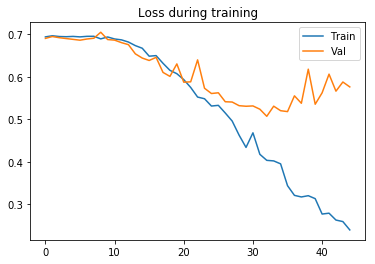

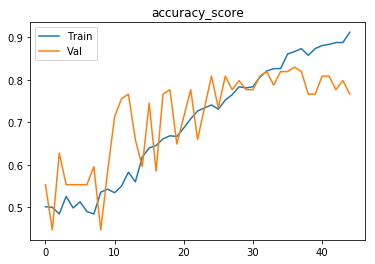

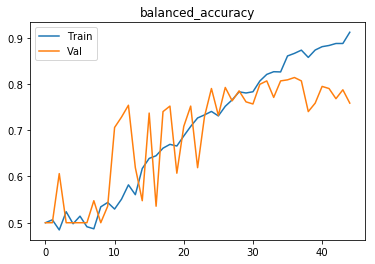

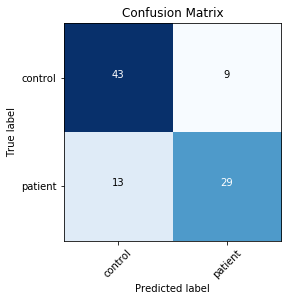

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69720
[0,   100] loss: 0.69295
Time elapsed: 0h:0m:15s
train accuracy_score: 50.00 %
train balanced_accuracy: 49.34 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.690463
[1,    50] loss: 0.69675
[1,   100] loss: 0.69224
Time elapsed: 0h:0m:32s
train accuracy_score: 52.42 %
train balanced_accuracy: 52.18 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.735111
[2,    50] loss: 0.69208
[2,   100] loss: 0.69353
Time elapsed: 0h:0m:49s
train accuracy_score: 52.28 %
train balanced_accuracy: 52.00 %
val accuracy_score: 50.00 %
val balanced_accuracy: 52.52 %
Val loss: 0.691463
[3,    50] loss: 0.69123
[3,   100] loss: 0.69387
Time elapsed: 0h:1m:7s
train accuracy_score: 55.13 %
train balanced_accuracy: 55.17 %
val accuracy_score: 65.96 %
val balanced_accuracy: 61.90 %
Val loss: 0.687672
[4,    50] 

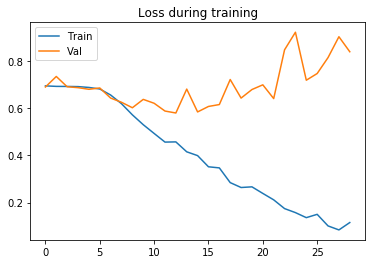

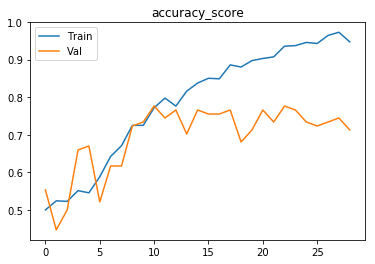

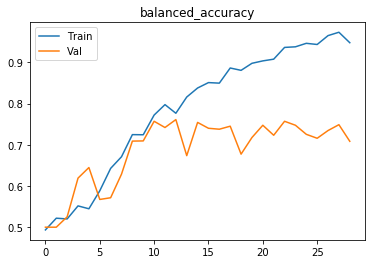

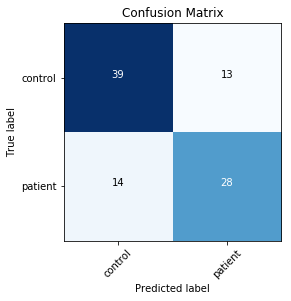

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69750
[0,   100] loss: 0.69500
[0,   150] loss: 0.69026
Time elapsed: 0h:0m:18s
train accuracy_score: 48.58 %
train balanced_accuracy: 47.98 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.694587
[1,    50] loss: 0.69418
[1,   100] loss: 0.69574
[1,   150] loss: 0.68964
Time elapsed: 0h:0m:38s
train accuracy_score: 49.57 %
train balanced_accuracy: 48.91 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.700374
[2,    50] loss: 0.69317
[2,   100] loss: 0.69793
[2,   150] loss: 0.68961
Time elapsed: 0h:0m:59s
train accuracy_score: 50.57 %
train balanced_accuracy: 49.85 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.692399
[3,    50] loss: 0.69321
[3,   100] loss: 0.69069
[3,   150] loss: 0.69485
Time elapsed: 0h:1m:19s
train accuracy_score: 52.14 %
train balanced_accura

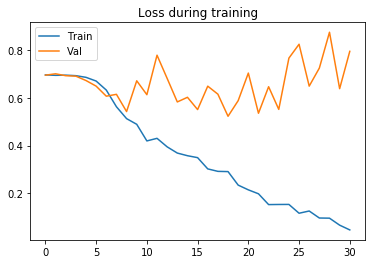

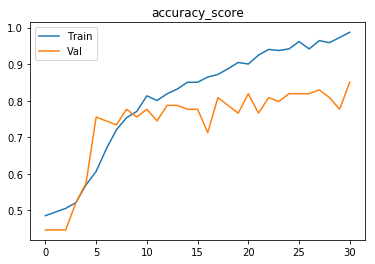

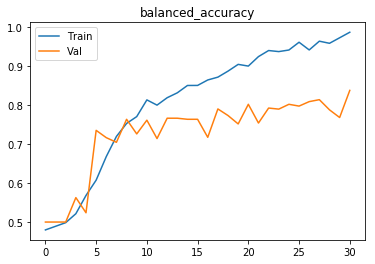

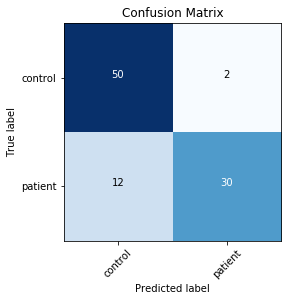

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69351
[0,   100] loss: 0.70147
Time elapsed: 0h:0m:9s
train accuracy_score: 50.28 %
train balanced_accuracy: 50.01 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.692536
[1,    50] loss: 0.69832
[1,   100] loss: 0.69462
Time elapsed: 0h:0m:20s
train accuracy_score: 49.72 %
train balanced_accuracy: 49.87 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
Val loss: 0.698681
[2,    50] loss: 0.69628
[2,   100] loss: 0.69435
Time elapsed: 0h:0m:32s
train accuracy_score: 51.28 %
train balanced_accuracy: 50.76 %
val accuracy_score: 58.51 %
val balanced_accuracy: 53.57 %
Val loss: 0.688082
[3,    50] loss: 0.69303
[3,   100] loss: 0.69605
Time elapsed: 0h:0m:43s
train accuracy_score: 52.14 %
train balanced_accuracy: 52.06 %
val accuracy_score: 58.51 %
val balanced_accuracy: 53.57 %
Val loss: 0.685274
[4,    50]

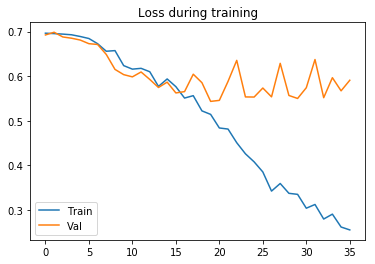

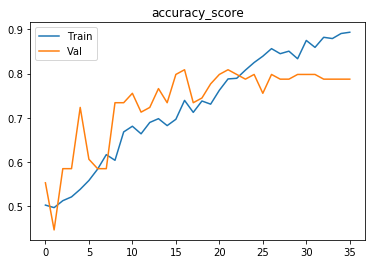

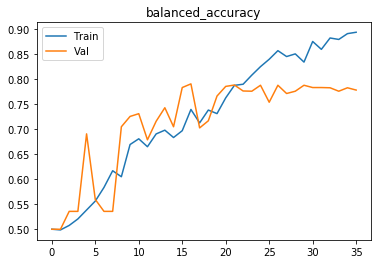

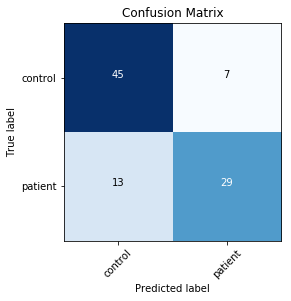

Finished outer fold.
{'final_acc': 0.8379120879120879, 'best_acc': 0.8379120879120879, 'final_iter': 31, 'best_iter': 31, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 8
# of patients 396, # of healthy controls 395
692
99
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69478
[0,   100] loss: 0.69511
Time elapsed: 0h:0m:9s
train accuracy_score: 47.54 %
train balanced_accuracy: 48.06 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.698589
[1,    50] loss: 0.69611
[1,   100] loss: 0.69482
Time elapsed: 0h:0m:21s
train accuracy_score: 47.25 %
train balanced_accuracy: 46.37 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.693871
[2,    50] loss: 0.69228
[2,   100] loss: 0.69352
Time elapsed: 0h:0m:32s
train accuracy_score: 55.06 %
train balanced_accuracy: 54.64 %
val

[36,    50] loss: 0.34896
[36,   100] loss: 0.40207
Time elapsed: 0h:6m:55s
train accuracy_score: 83.09 %
train balanced_accuracy: 83.10 %
val accuracy_score: 85.86 %
val balanced_accuracy: 85.64 %
Val loss: 0.338487
[37,    50] loss: 0.36633
[37,   100] loss: 0.43182
Time elapsed: 0h:7m:6s
train accuracy_score: 83.53 %
train balanced_accuracy: 83.57 %
val accuracy_score: 85.86 %
val balanced_accuracy: 85.64 %
Val loss: 0.336247
[38,    50] loss: 0.42260
[38,   100] loss: 0.35625
Time elapsed: 0h:7m:18s
train accuracy_score: 81.79 %
train balanced_accuracy: 81.85 %
val accuracy_score: 84.85 %
val balanced_accuracy: 84.81 %
Val loss: 0.326978
[39,    50] loss: 0.36273
[39,   100] loss: 0.38991
Time elapsed: 0h:7m:29s
train accuracy_score: 83.38 %
train balanced_accuracy: 83.36 %
val accuracy_score: 88.89 %
val balanced_accuracy: 86.35 %
Val loss: 0.336268
[40,    50] loss: 0.38245
[40,   100] loss: 0.40893
Time elapsed: 0h:7m:40s
train accuracy_score: 83.24 %
train balanced_accuracy: 83

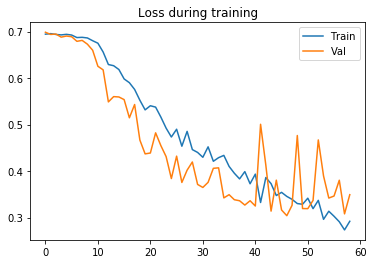

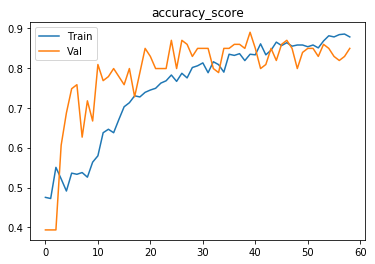

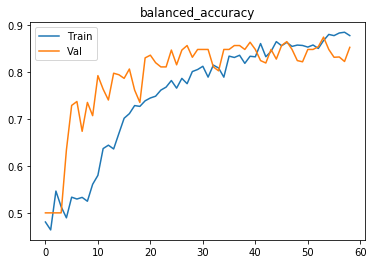

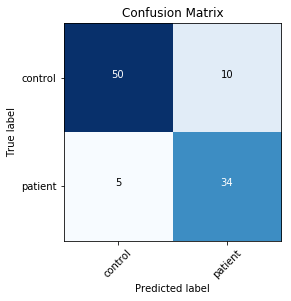

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69676
[0,   100] loss: 0.69662
Time elapsed: 0h:0m:9s
train accuracy_score: 51.01 %
train balanced_accuracy: 50.78 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.701357
[1,    50] loss: 0.69568
[1,   100] loss: 0.69176
Time elapsed: 0h:0m:20s
train accuracy_score: 51.88 %
train balanced_accuracy: 51.49 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.704776
[2,    50] loss: 0.69335
[2,   100] loss: 0.69164
Time elapsed: 0h:0m:31s
train accuracy_score: 54.05 %
train balanced_accuracy: 54.13 %
val accuracy_score: 43.43 %
val balanced_accuracy: 53.33 %
Val loss: 0.692364
[3,    50] loss: 0.69284
[3,   100] loss: 0.69400
Time elapsed: 0h:0m:43s
train accuracy_score: 52.17 %
train balanced_accuracy: 51.67 %
val accuracy_score: 58.59 %
val balanced_accuracy: 65.38 %
Val loss: 0.691051
[4,    50]

val accuracy_score: 80.81 %
val balanced_accuracy: 83.72 %
Val loss: 0.451605
[38,    50] loss: 0.30076
[38,   100] loss: 0.32670
Time elapsed: 0h:7m:18s
train accuracy_score: 86.85 %
train balanced_accuracy: 86.83 %
val accuracy_score: 82.83 %
val balanced_accuracy: 82.69 %
Val loss: 0.327885
[39,    50] loss: 0.25841
[39,   100] loss: 0.28570
Time elapsed: 0h:7m:29s
train accuracy_score: 87.57 %
train balanced_accuracy: 87.61 %
val accuracy_score: 76.77 %
val balanced_accuracy: 78.59 %
Val loss: 0.445351
[40,    50] loss: 0.23805
[40,   100] loss: 0.29911
Time elapsed: 0h:7m:41s
train accuracy_score: 90.75 %
train balanced_accuracy: 90.77 %
val accuracy_score: 83.84 %
val balanced_accuracy: 83.53 %
Val loss: 0.337508
[41,    50] loss: 0.28752
[41,   100] loss: 0.34315
Time elapsed: 0h:7m:52s
train accuracy_score: 86.71 %
train balanced_accuracy: 86.77 %
val accuracy_score: 81.82 %
val balanced_accuracy: 82.76 %
Val loss: 0.368773
[42,    50] loss: 0.24387
[42,   100] loss: 0.25196
Ti

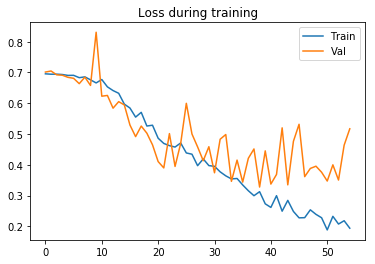

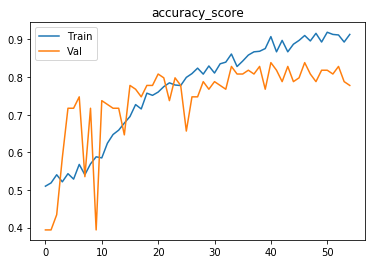

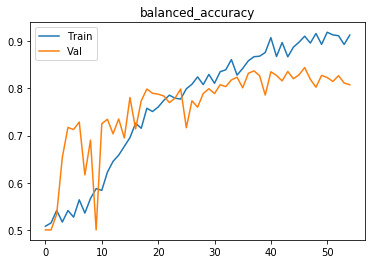

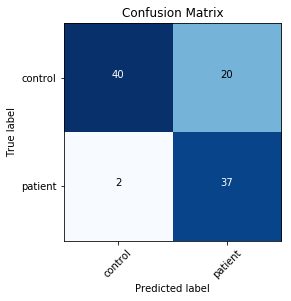

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69720
[0,   100] loss: 0.69398
[0,   150] loss: 0.69554
Time elapsed: 0h:0m:17s
train accuracy_score: 50.29 %
train balanced_accuracy: 50.69 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.715446
[1,    50] loss: 0.69738
[1,   100] loss: 0.69789
[1,   150] loss: 0.69799
Time elapsed: 0h:0m:37s
train accuracy_score: 52.46 %
train balanced_accuracy: 51.94 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.677047
[2,    50] loss: 0.69678
[2,   100] loss: 0.69837
[2,   150] loss: 0.69886
Time elapsed: 0h:0m:57s
train accuracy_score: 47.54 %
train balanced_accuracy: 47.96 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.690011
[3,    50] loss: 0.69188
[3,   100] loss: 0.69833
[3,   150] loss: 0.69488
Time elapsed: 0h:1m:18s
train accuracy_score: 50.43 %
train balanced_accura

Time elapsed: 0h:11m:21s
train accuracy_score: 98.55 %
train balanced_accuracy: 98.56 %
val accuracy_score: 85.86 %
val balanced_accuracy: 87.44 %
Val loss: 0.427946
[34,    50] loss: 0.04007
[34,   100] loss: 0.05009
[34,   150] loss: 0.02055
Time elapsed: 0h:11m:41s
train accuracy_score: 98.84 %
train balanced_accuracy: 98.86 %
val accuracy_score: 84.85 %
val balanced_accuracy: 87.50 %
Val loss: 0.591806
[35,    50] loss: 0.03507
[35,   100] loss: 0.04376
[35,   150] loss: 0.10177
Time elapsed: 0h:12m:2s
train accuracy_score: 97.98 %
train balanced_accuracy: 97.97 %
val accuracy_score: 85.86 %
val balanced_accuracy: 87.44 %
Val loss: 0.430695
[36,    50] loss: 0.02906
[36,   100] loss: 0.03478
[36,   150] loss: 0.06079
Time elapsed: 0h:12m:22s
train accuracy_score: 98.70 %
train balanced_accuracy: 98.72 %
val accuracy_score: 86.87 %
val balanced_accuracy: 86.03 %
Val loss: 0.405718
[37,    50] loss: 0.02467
[37,   100] loss: 0.04586
[37,   150] loss: 0.05271
Time elapsed: 0h:12m:42s


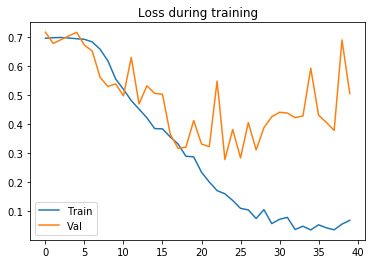

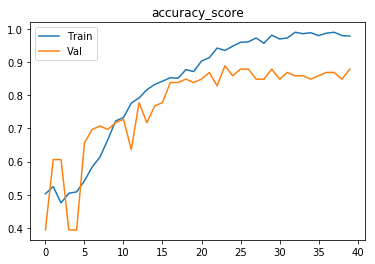

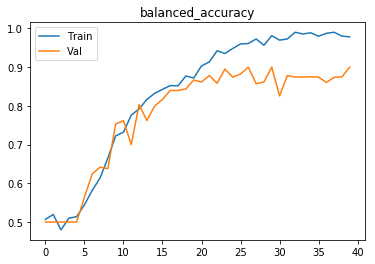

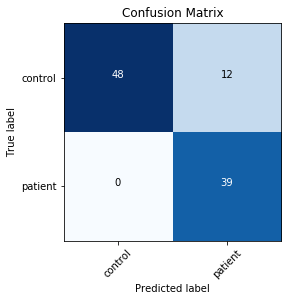

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69420
Time elapsed: 0h:0m:12s
train accuracy_score: 50.87 %
train balanced_accuracy: 51.04 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.695771
[1,    50] loss: 0.69498
Time elapsed: 0h:0m:26s
train accuracy_score: 50.43 %
train balanced_accuracy: 50.52 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
Val loss: 0.705179
[2,    50] loss: 0.69841
Time elapsed: 0h:0m:40s
train accuracy_score: 47.69 %
train balanced_accuracy: 47.55 %
val accuracy_score: 55.56 %
val balanced_accuracy: 59.29 %
Val loss: 0.692365
[3,    50] loss: 0.69332
Time elapsed: 0h:0m:55s
train accuracy_score: 53.03 %
train balanced_accuracy: 52.57 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.682634
[4,    50] loss: 0.69173
Time elapsed: 0h:1m:9s
train accuracy_score: 52.60 %
train balanced_accuracy: 52.88 

val accuracy_score: 83.84 %
val balanced_accuracy: 84.42 %
Val loss: 0.285857
[43,    50] loss: 0.12454
Time elapsed: 0h:10m:28s
train accuracy_score: 95.95 %
train balanced_accuracy: 96.00 %
val accuracy_score: 86.87 %
val balanced_accuracy: 89.17 %
Val loss: 0.424421
[44,    50] loss: 0.13850
Time elapsed: 0h:10m:43s
train accuracy_score: 95.95 %
train balanced_accuracy: 95.96 %
val accuracy_score: 83.84 %
val balanced_accuracy: 83.97 %
Val loss: 0.338074
[45,    50] loss: 0.09833
Time elapsed: 0h:10m:57s
train accuracy_score: 96.53 %
train balanced_accuracy: 96.54 %
val accuracy_score: 84.85 %
val balanced_accuracy: 85.71 %
Val loss: 0.337099
[46,    50] loss: 0.13295
Time elapsed: 0h:11m:12s
train accuracy_score: 94.94 %
train balanced_accuracy: 94.93 %
val accuracy_score: 80.81 %
val balanced_accuracy: 79.68 %
Val loss: 0.309870
[47,    50] loss: 0.11533
Time elapsed: 0h:11m:26s
train accuracy_score: 96.39 %
train balanced_accuracy: 96.39 %
val accuracy_score: 87.88 %
val balanced

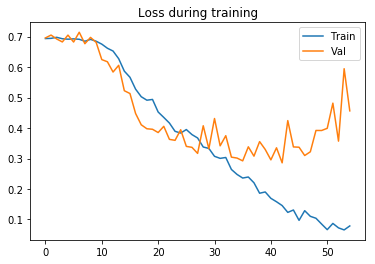

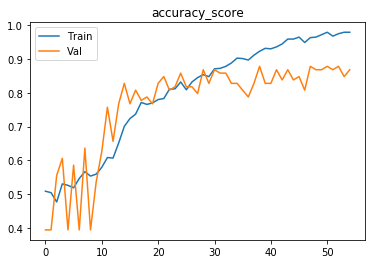

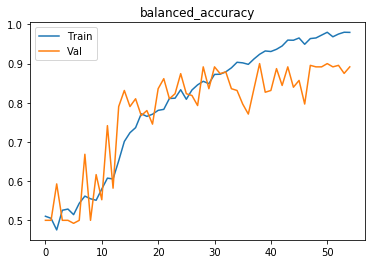

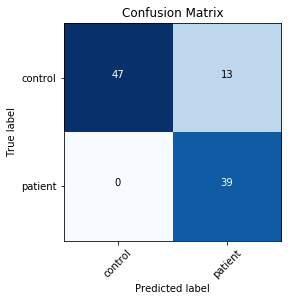

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69766
Time elapsed: 0h:0m:7s
train accuracy_score: 45.52 %
train balanced_accuracy: 46.31 %
val accuracy_score: 41.41 %
val balanced_accuracy: 49.42 %
Val loss: 0.693955
[1,    50] loss: 0.69767
Time elapsed: 0h:0m:16s
train accuracy_score: 49.13 %
train balanced_accuracy: 48.44 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.688104
[2,    50] loss: 0.69322
Time elapsed: 0h:0m:25s
train accuracy_score: 51.59 %
train balanced_accuracy: 52.09 %
val accuracy_score: 43.43 %
val balanced_accuracy: 53.33 %
Val loss: 0.698031
[3,    50] loss: 0.69428
Time elapsed: 0h:0m:35s
train accuracy_score: 48.55 %
train balanced_accuracy: 47.90 %
val accuracy_score: 60.61 %
val balanced_accuracy: 50.00 %
Val loss: 0.682775
[4,    50] loss: 0.69457
Time elapsed: 0h:0m:44s
train accuracy_score: 48.84 %
train balanced_accuracy: 49.30

val accuracy_score: 85.86 %
val balanced_accuracy: 87.88 %
Val loss: 0.335798
[43,    50] loss: 0.20493
Time elapsed: 0h:6m:47s
train accuracy_score: 92.49 %
train balanced_accuracy: 92.47 %
val accuracy_score: 88.89 %
val balanced_accuracy: 90.38 %
Val loss: 0.280370
[44,    50] loss: 0.21025
Time elapsed: 0h:6m:56s
train accuracy_score: 92.77 %
train balanced_accuracy: 92.77 %
val accuracy_score: 89.90 %
val balanced_accuracy: 91.22 %
Val loss: 0.275241
[45,    50] loss: 0.20636
Time elapsed: 0h:7m:6s
train accuracy_score: 91.76 %
train balanced_accuracy: 91.75 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.77 %
Val loss: 0.234074
[46,    50] loss: 0.20477
Time elapsed: 0h:7m:15s
train accuracy_score: 90.61 %
train balanced_accuracy: 90.62 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.32 %
Val loss: 0.220202
[47,    50] loss: 0.20354
Time elapsed: 0h:7m:24s
train accuracy_score: 92.63 %
train balanced_accuracy: 92.60 %
val accuracy_score: 88.89 %
val balanced_accur

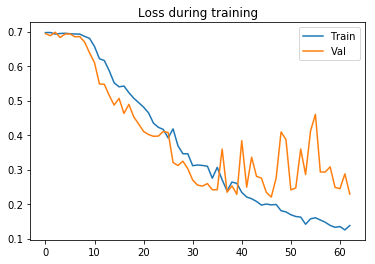

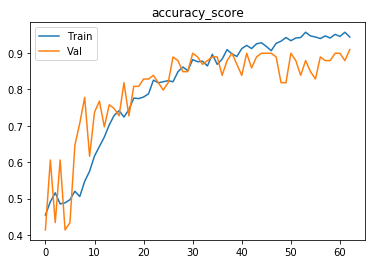

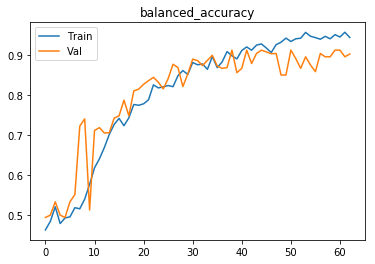

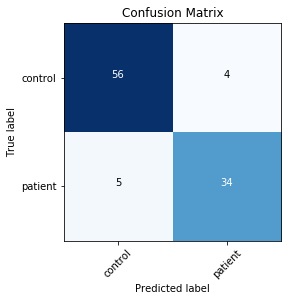

Finished outer fold.
{'final_acc': 0.9000000000000001, 'best_acc': 0.9000000000000001, 'final_iter': 40, 'best_iter': 40, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 9
# of patients 403, # of healthy controls 398
689
112
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69335
Time elapsed: 0h:0m:7s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.22 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695383
[1,    50] loss: 0.69299
Time elapsed: 0h:0m:16s
train accuracy_score: 49.78 %
train balanced_accuracy: 49.58 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693293
[2,    50] loss: 0.69334
Time elapsed: 0h:0m:26s
train accuracy_score: 51.52 %
train balanced_accuracy: 50.60 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.69415

[41,    50] loss: 0.42723
Time elapsed: 0h:6m:30s
train accuracy_score: 81.42 %
train balanced_accuracy: 81.46 %
val accuracy_score: 68.75 %
val balanced_accuracy: 70.35 %
Val loss: 0.620023
[42,    50] loss: 0.41089
Time elapsed: 0h:6m:39s
train accuracy_score: 83.45 %
train balanced_accuracy: 83.48 %
val accuracy_score: 76.79 %
val balanced_accuracy: 75.47 %
Val loss: 0.583461
[43,    50] loss: 0.40944
Time elapsed: 0h:6m:48s
train accuracy_score: 82.58 %
train balanced_accuracy: 82.61 %
val accuracy_score: 80.36 %
val balanced_accuracy: 79.72 %
Val loss: 0.558556
[44,    50] loss: 0.37377
Time elapsed: 0h:6m:58s
train accuracy_score: 83.60 %
train balanced_accuracy: 83.61 %
val accuracy_score: 78.57 %
val balanced_accuracy: 77.76 %
Val loss: 0.550313
[45,    50] loss: 0.38045
Time elapsed: 0h:7m:7s
train accuracy_score: 83.74 %
train balanced_accuracy: 83.80 %
val accuracy_score: 79.46 %
val balanced_accuracy: 78.90 %
Val loss: 0.556705
[46,    50] loss: 0.37198
Time elapsed: 0h:7m:

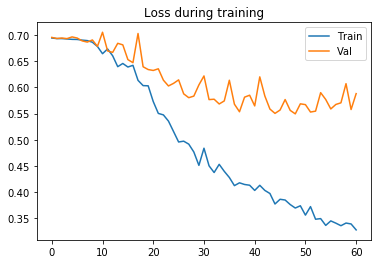

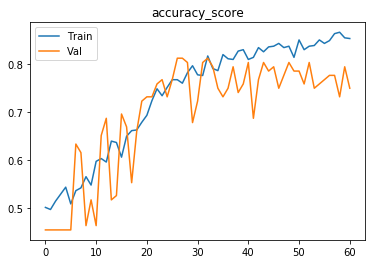

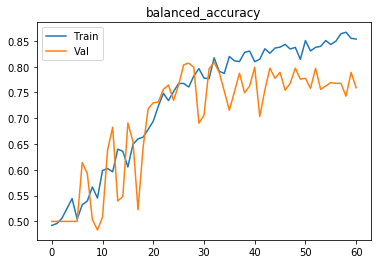

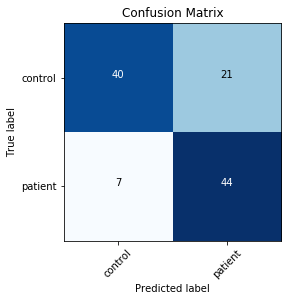

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    50] loss: 0.69446
Time elapsed: 0h:0m:7s
train accuracy_score: 51.52 %
train balanced_accuracy: 50.91 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693914
[1,    50] loss: 0.69523
Time elapsed: 0h:0m:16s
train accuracy_score: 48.48 %
train balanced_accuracy: 48.06 %
val accuracy_score: 46.43 %
val balanced_accuracy: 50.34 %
Val loss: 0.693248
[2,    50] loss: 0.69443
Time elapsed: 0h:0m:26s
train accuracy_score: 50.65 %
train balanced_accuracy: 50.04 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.696671
[3,    50] loss: 0.69323
Time elapsed: 0h:0m:35s
train accuracy_score: 51.67 %
train balanced_accuracy: 50.68 %
val accuracy_score: 58.93 %
val balanced_accuracy: 56.35 %
Val loss: 0.691472
[4,    50] loss: 0.69344
Time elapsed: 0h:0m:44s
train accuracy_score: 50.80 %
train balanced_accuracy: 50.20

val accuracy_score: 75.89 %
val balanced_accuracy: 75.14 %
Val loss: 0.668681
[43,    50] loss: 0.30769
Time elapsed: 0h:6m:50s
train accuracy_score: 86.65 %
train balanced_accuracy: 86.65 %
val accuracy_score: 77.68 %
val balanced_accuracy: 77.10 %
Val loss: 0.628451
[44,    50] loss: 0.28116
Time elapsed: 0h:6m:59s
train accuracy_score: 89.11 %
train balanced_accuracy: 89.13 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.96 %
Val loss: 0.626951
Early stopping in epoch 45
Total time elapsed: 0h:7m:1s
Writing model to disk...
Best result during training: 0.77. Saving model..
Finished inner fold.


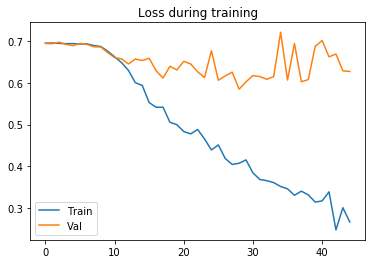

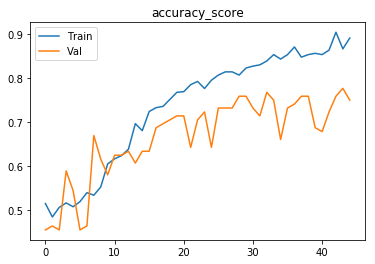

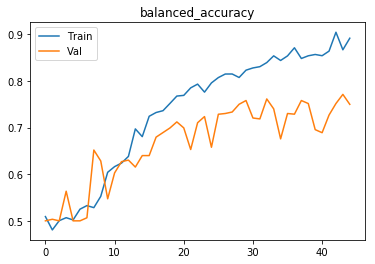

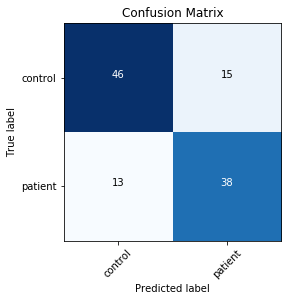

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69612
Time elapsed: 0h:0m:12s
train accuracy_score: 46.01 %
train balanced_accuracy: 46.50 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691425
[1,    50] loss: 0.69378
Time elapsed: 0h:0m:26s
train accuracy_score: 49.93 %
train balanced_accuracy: 49.72 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690999
[2,    50] loss: 0.69501
Time elapsed: 0h:0m:41s
train accuracy_score: 51.09 %
train balanced_accuracy: 51.32 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.689107
[3,    50] loss: 0.69468
Time elapsed: 0h:0m:55s
train accuracy_score: 49.64 %
train balanced_accuracy: 50.06 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.691984
[4,    50] loss: 0.69165
Time elapsed: 0h:1m:9s
train accuracy_score: 53.99 %
train balanced_accuracy: 53.81 

val accuracy_score: 81.25 %
val balanced_accuracy: 81.18 %
Val loss: 0.519457
[43,    50] loss: 0.14521
Time elapsed: 0h:10m:23s
train accuracy_score: 94.19 %
train balanced_accuracy: 94.22 %
val accuracy_score: 80.36 %
val balanced_accuracy: 80.36 %
Val loss: 0.550245
[44,    50] loss: 0.15489
Time elapsed: 0h:10m:38s
train accuracy_score: 94.05 %
train balanced_accuracy: 94.07 %
val accuracy_score: 81.25 %
val balanced_accuracy: 80.70 %
Val loss: 0.566645
[45,    50] loss: 0.14385
Time elapsed: 0h:10m:52s
train accuracy_score: 95.07 %
train balanced_accuracy: 95.08 %
val accuracy_score: 80.36 %
val balanced_accuracy: 80.36 %
Val loss: 0.575784
[46,    50] loss: 0.14459
Time elapsed: 0h:11m:6s
train accuracy_score: 94.48 %
train balanced_accuracy: 94.48 %
val accuracy_score: 81.25 %
val balanced_accuracy: 81.18 %
Val loss: 0.534056
[47,    50] loss: 0.10497
Time elapsed: 0h:11m:20s
train accuracy_score: 97.39 %
train balanced_accuracy: 97.41 %
val accuracy_score: 81.25 %
val balanced_

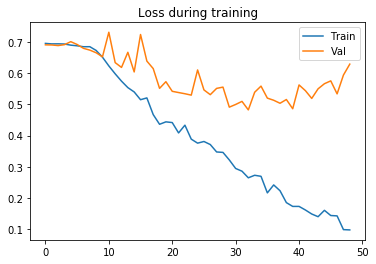

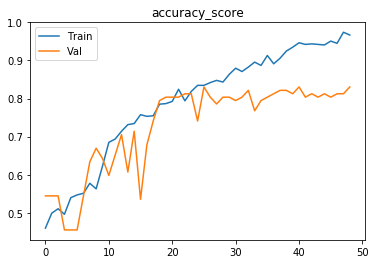

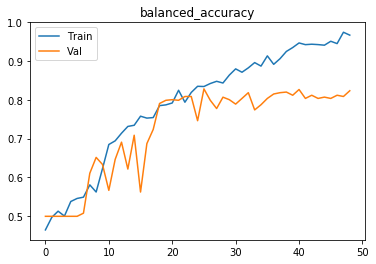

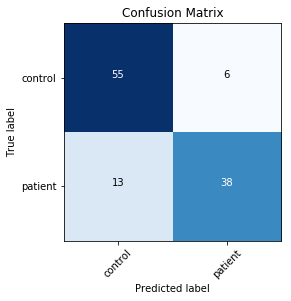

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    50] loss: 0.69410
[0,   100] loss: 0.69397
Time elapsed: 0h:0m:14s
train accuracy_score: 52.69 %
train balanced_accuracy: 51.90 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688984
[1,    50] loss: 0.69408
[1,   100] loss: 0.69800
Time elapsed: 0h:0m:32s
train accuracy_score: 48.62 %
train balanced_accuracy: 48.39 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694670
[2,    50] loss: 0.69529
[2,   100] loss: 0.69287
Time elapsed: 0h:0m:48s
train accuracy_score: 50.22 %
train balanced_accuracy: 49.25 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693776
[3,    50] loss: 0.69192
[3,   100] loss: 0.69443
Time elapsed: 0h:1m:5s
train accuracy_score: 52.98 %
train balanced_accuracy: 52.75 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.688521
[4,    50] 

val accuracy_score: 82.14 %
val balanced_accuracy: 81.36 %
Val loss: 0.806796
[38,    50] loss: 0.08049
[38,   100] loss: 0.06880
Time elapsed: 0h:11m:1s
train accuracy_score: 97.10 %
train balanced_accuracy: 97.10 %
val accuracy_score: 78.57 %
val balanced_accuracy: 78.40 %
Val loss: 0.723740
[39,    50] loss: 0.05687
[39,   100] loss: 0.05744
Time elapsed: 0h:11m:17s
train accuracy_score: 98.11 %
train balanced_accuracy: 98.12 %
val accuracy_score: 81.25 %
val balanced_accuracy: 80.86 %
Val loss: 0.756370
[40,    50] loss: 0.05135
[40,   100] loss: 0.04196
Time elapsed: 0h:11m:34s
train accuracy_score: 98.55 %
train balanced_accuracy: 98.55 %
val accuracy_score: 80.36 %
val balanced_accuracy: 80.04 %
Val loss: 0.785491
[41,    50] loss: 0.03305
[41,   100] loss: 0.03718
Time elapsed: 0h:11m:52s
train accuracy_score: 98.98 %
train balanced_accuracy: 98.98 %
val accuracy_score: 76.79 %
val balanced_accuracy: 76.76 %
Val loss: 0.755822
Early stopping in epoch 42
Total time elapsed: 0h:1

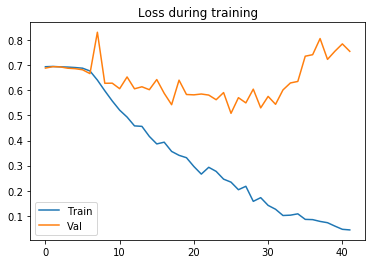

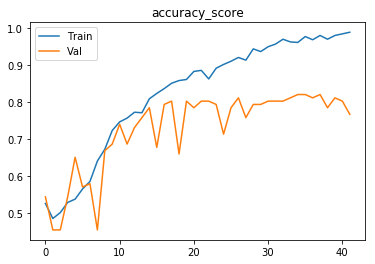

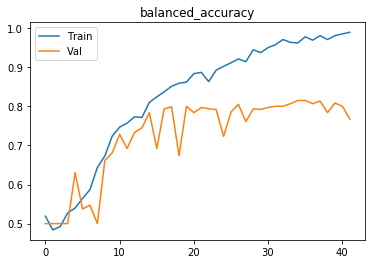

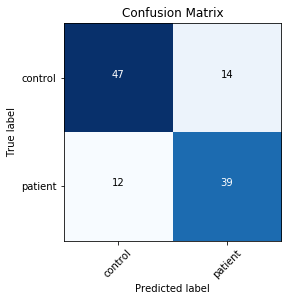

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    50] loss: 0.69417
[0,   100] loss: 0.69235
[0,   150] loss: 0.69425
Time elapsed: 0h:0m:11s
train accuracy_score: 51.67 %
train balanced_accuracy: 50.89 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690245
[1,    50] loss: 0.69366
[1,   100] loss: 0.69311
[1,   150] loss: 0.69708
Time elapsed: 0h:0m:24s
train accuracy_score: 50.65 %
train balanced_accuracy: 50.59 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695369
[2,    50] loss: 0.69507
[2,   100] loss: 0.69245
[2,   150] loss: 0.69007
Time elapsed: 0h:0m:37s
train accuracy_score: 50.80 %
train balanced_accuracy: 50.56 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.698525
[3,    50] loss: 0.69489
[3,   100] loss: 0.70041
[3,   150] loss: 0.69487
Time elapsed: 0h:0m:50s
train accuracy_score: 52.39 %
train balanced_accura

val accuracy_score: 76.79 %
val balanced_accuracy: 75.63 %
Val loss: 0.575736
[34,    50] loss: 0.42537
[34,   100] loss: 0.37584
[34,   150] loss: 0.37348
Time elapsed: 0h:7m:39s
train accuracy_score: 81.86 %
train balanced_accuracy: 81.87 %
val accuracy_score: 75.89 %
val balanced_accuracy: 75.14 %
Val loss: 0.597720
[35,    50] loss: 0.45929
[35,   100] loss: 0.38648
[35,   150] loss: 0.38234
Time elapsed: 0h:7m:52s
train accuracy_score: 81.28 %
train balanced_accuracy: 81.34 %
val accuracy_score: 62.50 %
val balanced_accuracy: 64.61 %
Val loss: 0.752936
[36,    50] loss: 0.38596
[36,   100] loss: 0.44066
[36,   150] loss: 0.36168
Time elapsed: 0h:8m:5s
train accuracy_score: 81.86 %
train balanced_accuracy: 81.87 %
val accuracy_score: 73.21 %
val balanced_accuracy: 73.16 %
Val loss: 0.594473
[37,    50] loss: 0.31051
[37,   100] loss: 0.43496
[37,   150] loss: 0.40241
Time elapsed: 0h:8m:18s
train accuracy_score: 83.89 %
train balanced_accuracy: 83.90 %
val accuracy_score: 70.54 %
v

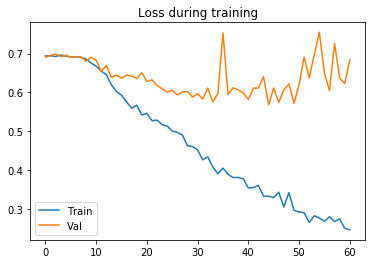

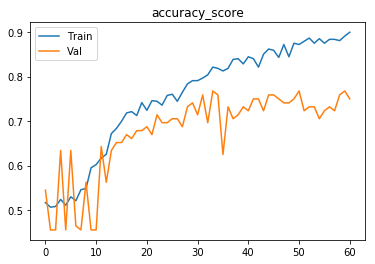

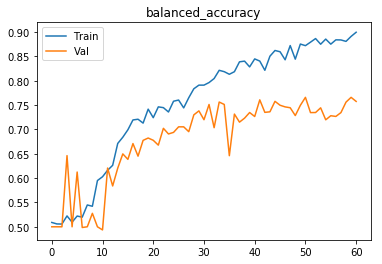

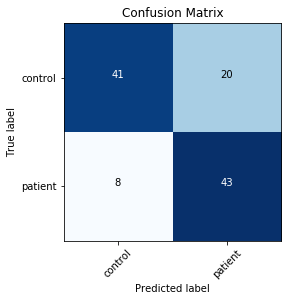

Finished outer fold.
{'final_acc': 0.8233686917389906, 'best_acc': 0.8281902925104466, 'final_iter': 49, 'best_iter': 26, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
################################
################################
All accuracies: [0.78835327234342, 0.8494018296973962, 0.8564391273750879, 0.818789584799437, 0.8611893033075299, 0.8829545454545454, 0.7852272727272727, 0.8045454545454545, 0.8931818181818181, 0.8772727272727272, 0.7551383399209486, 0.7697628458498025, 0.7784584980237154, 0.8059288537549407, 0.8369565217391304, 0.8140350877192982, 0.8175438596491229, 0.8258771929824562, 0.8271929824561405, 0.8188596491228072, 0.7726763717805151, 0.8577827547592385, 0.8540500186636805, 0.8590892123926839, 0.8077640910787607, 0.8294681508967223, 0.8531230674087817, 0.8024118738404453, 0.8181818181818181, 0.8432282003710575, 0.8638888888888889, 0.7696428571428571, 0.8412698412698412, 0.774206349206349, 0.8501984126984127, 

In [17]:
fold_metric, models = run(net=None, data=None,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [18]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [19]:
training_res = [{'final_acc': 0.8564391273750879, 'best_acc': 0.9020056298381421, 'final_iter': 29, 'best_iter': 23, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8931818181818181, 'best_acc': 0.9659090909090908, 'final_iter': 38, 'best_iter': 26, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.8369565217391304, 'best_acc': 0.8369565217391304, 'final_iter': 80, 'best_iter': 80, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}, {'final_acc': 0.8188596491228072, 'best_acc': 0.8842105263157896, 'final_iter': 47, 'best_iter': 43, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}, {'final_acc': 0.8577827547592385, 'best_acc': 0.8822321761851437, 'final_iter': 66, 'best_iter': 56, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}, {'final_acc': 0.8432282003710575, 'best_acc': 0.9186765615337045, 'final_iter': 109, 'best_iter': 106, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}, {'final_acc': 0.8501984126984127, 'best_acc': 0.8968253968253966, 'final_iter': 34, 'best_iter': 32, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}, {'final_acc': 0.8379120879120879, 'best_acc': 0.8379120879120879, 'final_iter': 31, 'best_iter': 31, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.9000000000000001, 'best_acc': 0.9000000000000001, 'final_iter': 40, 'best_iter': 40, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8233686917389906, 'best_acc': 0.8281902925104466, 'final_iter': 49, 'best_iter': 26, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}]

In [20]:
print(len(training_res))
res_df = pd.DataFrame(training_res)

10


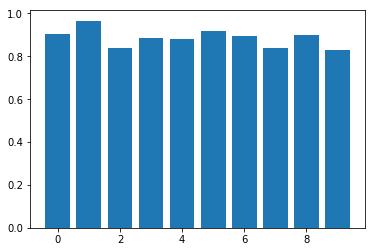

0.8852918283768932
0.8517927263898631


In [21]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [22]:
print(np.mean(res_df["final_iter"]))

52.3


In [23]:
print(res_df["final_iter"])

0     29
1     38
2     80
3     47
4     66
5    109
6     34
7     31
8     40
9     49
Name: final_iter, dtype: int64


In [25]:
from collections import OrderedDict

In [28]:
metrics = []
random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    test_h5 = h5py.File(train_data_path.replace("train", "holdout") + str(r) + ".h5", 'r')

    X_test, y_test = np.array(test_h5['X']), np.array(test_h5['y'])

    # dataset overview
    print("# of patients {}, # of healthy controls {}".format(np.sum(y_test), len(y_test)-np.sum(y_test)))

    print(len(y_test))

    if zero_one_normalize:
        intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
        adni_data_test= ADNIDataset(X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    else:
        adni_data_test = ADNIDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

    test_h5.close()
    
    test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False)
    
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Outer fold 0
# of patients 65, # of healthy controls 98
163
Bal. accuracy 72.402 %
ROC AUC Score 83.673 %
Sensitivity 81.538 %
Specificity 63.265 %
Outer fold 1
# of patients 77, # of healthy controls 99
176
Bal. accuracy 87.662 %
ROC AUC Score 93.323 %
Sensitivity 93.506 %
Specificity 81.818 %
Outer fold 2
# of patients 78, # of healthy controls 100
178
Bal. accuracy 88.231 %
ROC AUC Score 91.782 %
Sensitivity 88.462 %
Specificity 88.000 %
Outer fold 3
# of patients 70, # of healthy controls 93
163
Bal. accuracy 86.782 %
ROC AUC Score 94.163 %
Sensitivity 75.714 %
Specificity 97.849 %
Outer fold 4
# of patients 73, # of healthy controls 96
169
Bal. accuracy 70.676 %
ROC AUC Score 80.579 %
Sensitivity 72.603 %
Specificity 68.750 %
Outer fold 5
# of patients 73, # of healthy controls 97
170
Bal. accuracy 87.827 %
ROC AUC Score 95.749 %
Sensitivity 84.932 %
Specificity 90.722 %
Outer fold 6
# of patients 68, # of healthy controls 90
158
Bal. accuracy 72.484 %
ROC AUC Score 77.255 %
Sensi